In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
import seaborn as sns
yf.pdr_override()

In [2]:
capital = 1e5
start_date = dt.datetime(2004,11,1)
end_date = dt.datetime(2023,11,1)

spy = pdr.get_data_yahoo("SPY", start = start_date, end = end_date)
Y = np.log(spy["Adj Close"]).diff(1).shift(-1)
Y.name = "Y_pred"
Y

[*********************100%***********************]  1 of 1 completed


Date
2004-11-01    0.000353
2004-11-02    0.012515
2004-11-03    0.013562
2004-11-04    0.006243
2004-11-05   -0.001450
                ...   
2023-10-25   -0.012047
2023-10-26   -0.004543
2023-10-27    0.011885
2023-10-30    0.006261
2023-10-31         NaN
Name: Y_pred, Length: 4783, dtype: float64

In [3]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Regularization
from sklearn.linear_model import Lasso #because we are selecting features.
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor #worst performer because there is no pruning?

# ENSEMBLE

## Bagging (bootstrap aggregation) #likely to overfit too because its underlying uses decision tree 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


# for cross-validation
from sklearn.model_selection import cross_val_score #perf, mean, variance and std error
from sklearn.model_selection import KFold # we can tune it as hyperparameter
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

#import dependency for time series modelling

import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

from pandas.plotting import scatter_matrix #plot of correlation matrix and kernel density plotting

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler


# ALTERNATIVE APPROACH TO GET MORE FEATURES

In [4]:
capital = 1e5
start_date = dt.datetime(2004,11,1)
end_date = dt.datetime(2023,11,1)

spy = pdr.get_data_yahoo("SPY", start = start_date, end = end_date)
Y = np.log(spy["Adj Close"]).diff(1).shift(-1)
Y.name = "Y_pred"

ticker = "^TNX"

tnx_data = yf.download(ticker, start=start_date, end=end_date)

X0 = np.log(tnx_data["Adj Close"])
X0 = X0.ffill()
X0.name = "10years futures"

X1 = np.log(spy["Volume"])
X2 =\
(pd.concat([Y.
            diff(i) 
            for i in [3,6,12]], 
                   axis = 1
          )
 #.dropna()
)
X2.columns = ["SPY_3", "SPY_6", "SPY_12"]

X3 =\
(
    pd.concat([X1.shift(i)
               #.diff(i) 
               for i in [3,6,12]],
                      axis =1
             )
)
X3.columns = ["Volume_3", "Volume_6", "Volume_12"]

X =\
(
        pd.concat([X0, X1, X2, X3],
                 axis = 1)
)

#no trading signal for the first 12 days
X_traintest = X.iloc[12:]
Y_traintest = Y.iloc[12:]

X_traintest = X_traintest.ffill()


#interpreting Y returns in binary signal
Y_traintest_binary = (Y_traintest > 0).astype(int)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
X_traintest

10years futures     Volume     SPY_3     SPY_6    SPY_12  \
Date                                                                   
2004-11-17         1.421662  17.813601 -0.001105  0.000579  0.000997   
2004-11-18         1.415125  17.276683 -0.003994 -0.018759 -0.023695   
2004-11-19         1.434132  17.809602 -0.001163 -0.003102 -0.008804   
2004-11-22         1.426716  17.441456  0.000175 -0.000930 -0.004720   
2004-11-23         1.431268  17.552437  0.013546  0.009552  0.003817   
...                     ...        ...       ...       ...       ...   
2023-10-25         1.599993  18.361177 -0.010312  0.001368 -0.017238   
2023-10-26         1.577947  18.561805 -0.012054  0.004282 -0.008631   
2023-10-27         1.577947  18.491770  0.026341  0.024249  0.018000   
2023-10-30         1.584120  18.276380  0.018308  0.007995  0.011254   
2023-10-31         1.584120  18.193343  0.018308  0.007995  0.011254   

             Volume_3   Volume_6  Volume_12  
Date                                         
2004-11-17  17.833401  17.614546  17.418857  
2004-11-18  17.379334  17.628054  17.844605  
2004-11-19  17.505107  17.449490  18.158799  
2004-11-22  17.813601  17.833401  17.829193  
2004-11-23  17.276683  17.379334  17.963194  
...               ...        ...        ...  
2023-10-25  18.634548  18.137319  18.202206  
2023-10-26  18.337681  18.354111  18.179975  
2023-10-27  18.179427  18.613967  17.949904  
2023-10-30  18.361177  18.634548  18.211862  
2023-10-31  18.561805  18.337681  18.370893  

[4771 rows x 8 columns]

In [6]:
X_traintest.describe()

10years futures       Volume        SPY_3        SPY_6       SPY_12  \
count      4771.000000  4771.000000  4771.000000  4771.000000  4771.000000   
mean          0.949562    18.485200     0.000006    -0.000003    -0.000014   
std           0.449800     0.594471     0.017087     0.017530     0.017018   
min          -0.695149    16.541401    -0.133988    -0.165887    -0.142856   
25%           0.676255    18.038105    -0.007521    -0.007547    -0.007762   
50%           0.982453    18.408187    -0.000337    -0.000367    -0.000343   
75%           1.307522    18.886602     0.007141     0.007140     0.007185   
max           1.657847    20.585183     0.161982     0.202618     0.135072   

          Volume_3     Volume_6    Volume_12  
count  4771.000000  4771.000000  4771.000000  
mean     18.484730    18.484225    18.483457  
std       0.594907     0.595339     0.595927  
min      16.541401    16.541401    16.541401  
25%      18.036886    18.035614    18.033281  
50%      18.407938    18.407802    18.405829  
75%      18.886602    18.886602    18.886602  
max      20.585183    20.585183    20.585183

In [7]:
Y_traintest

Date
2004-11-17    0.001349
2004-11-18   -0.011179
2004-11-19    0.004758
2004-11-22    0.001524
2004-11-23    0.002367
                ...   
2023-10-25   -0.012047
2023-10-26   -0.004543
2023-10-27    0.011885
2023-10-30    0.006261
2023-10-31         NaN
Name: Y_pred, Length: 4771, dtype: float64

In [8]:
X_traintest.isna().any()

10years futures    False
Volume             False
SPY_3              False
SPY_6              False
SPY_12             False
Volume_3           False
Volume_6           False
Volume_12          False
dtype: bool

In [9]:
 Y_traintest.shift(-1)

Date
2004-11-17   -0.011179
2004-11-18    0.004758
2004-11-19    0.001524
2004-11-22    0.002367
2004-11-23   -0.000760
                ...   
2023-10-25   -0.004543
2023-10-26    0.011885
2023-10-27    0.006261
2023-10-30         NaN
2023-10-31         NaN
Name: Y_pred, Length: 4771, dtype: float64

In [11]:
# Engineering more features
# Uses F-statistics to determine model significance

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)

index_ = Y_traintest.shift(-1).dropna().index 

X_poly = poly.fit_transform(X_traintest.loc[index_])


from sklearn.feature_selection import SelectKBest, f_regression
#(R-squared / (1 - R-squared)) * ((n - k - 1) / k)

selector = SelectKBest(score_func=f_regression, k=10) #marginal improvement from when k = 8. big improvement from k = 5

#we are shifting the Y values because we need to train the model for a 1 day look ahead
X_selected = selector.fit_transform(X_poly, Y_traintest.shift(-1).loc[index_]) #Y_traintest_binary

X_selected

array([[ 0.01031352,  0.01032499,  0.18372099, ...,  0.18186996,
         0.17984946,  0.17963802],
       [-0.3240971 , -0.32602276, -5.59932289, ..., -5.74714661,
        -5.8177474 , -5.82939529],
       [-0.05523747, -0.05429307, -0.9837574 , ..., -0.94738631,
        -0.98589686, -0.94437629],
       ...,
       [ 0.02511368,  0.02548758,  0.46111664, ...,  0.46227637,
         0.4639302 ,  0.44994137],
       [ 0.07948454,  0.0785248 ,  1.47537654, ...,  1.44125298,
         1.42757896,  1.44254435],
       [ 0.44840785,  0.44083382,  8.29185472, ...,  8.20566612,
         7.91292472,  8.40180501]])

In [12]:
#get the features name used. Volume could be a cross-product or of a higher power

X_columns = selector.get_feature_names_out()

In [13]:
X_columns

array(['x19', 'x32', 'x83', 'x96', 'x97', 'x98', 'x139', 'x140', 'x141',
       'x142'], dtype=object)

In [14]:
X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = X_traintest.iloc[:-2].index)

In [15]:
X_selected_df

x19       x32       x83       x96       x97       x98  \
Date                                                                     
2004-11-17  0.010314  0.010325  0.183721  0.183925  0.181668  0.179650   
2004-11-18 -0.324097 -0.326023 -5.599323 -5.632592 -5.713201 -5.783385   
2004-11-19 -0.055237 -0.054293 -0.983757 -0.966938 -0.963866 -1.003046   
2004-11-22 -0.016223 -0.016569 -0.282945 -0.288982 -0.289303 -0.289235   
2004-11-23  0.167661  0.165027  2.942852  2.896619  2.913830  3.011720   
...              ...       ...       ...       ...       ...       ...   
2023-10-23 -0.054195 -0.054243 -0.993806 -0.994697 -0.995606 -0.979085   
2023-10-24 -0.261970 -0.268232 -4.762470 -4.876307 -4.751816 -4.858158   
2023-10-25  0.025114  0.025488  0.461117  0.467982  0.455495  0.457124   
2023-10-26  0.079485  0.078525  1.475377  1.457562  1.458868  1.445027   
2023-10-27  0.448408  0.440834  8.291855  8.151798  8.346649  8.048878   

                x139      x140      x141      x142  
Date                                                
2004-11-17  0.184130  0.181870  0.179849  0.179638  
2004-11-18 -5.666058 -5.747147 -5.817747 -5.829395  
2004-11-19 -0.950406 -0.947386 -0.985897 -0.944376  
2004-11-22 -0.295148 -0.295476 -0.295406 -0.295805  
2004-11-23  2.851112  2.868053  2.964405  2.885093  
...              ...       ...       ...       ...  
2023-10-23 -0.995588 -0.996498 -0.979962 -0.997409  
2023-10-24 -4.992864 -4.865398 -4.974282 -4.741186  
2023-10-25  0.474950  0.462276  0.463930  0.449941  
2023-10-26  1.439963  1.441253  1.427579  1.442544  
2023-10-27  8.014106  8.205666  7.912925  8.401805  

[4769 rows x 10 columns]

In [16]:
#from sklearn.linear_model import Ridge
#from sklearn.linear_model import Lasso

#between 0 to 1 where 0 is Ridge and 1 is Lasso
penalty_ = 0.0

#linear_regression2 = LinearRegression()
elastic_net = ElasticNet(alpha=0.1, l1_ratio=penalty_)
#ridge_model = Ridge(alpha=1.0)
index_ = X_selected_df.index
elastic_net.fit(X_selected_df, Y_traintest.shift(-1).loc[index_])
print("intercept is {:.3f} and coefficients are {}".format(elastic_net.intercept_, elastic_net.coef_))

EN_pred_train2 = elastic_net.predict(X_selected_df)
print(EN_pred_train2)

#continuous predictions are turned into binary signal or 1 and 0 

Y_pred_binary2 = (EN_pred_train2 > 0.0).astype(int)
Y_pred_binary2

logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver = "saga")
logreg_sk2.fit(X_selected_df, Y_pred_binary2)
print("intercept is {:.3f} and coefficients are {}".format(logreg_sk2.intercept_[0], logreg_sk2.coef_[0]))

Y_pred_logistic2 = logreg_sk2.predict(X_selected_df)

print("Name of features used: {}".format(elastic_net.feature_names_in_))
print(" ")
print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.iloc[:-2], Y_pred_logistic2))
print(" ")
print("Precision :", metrics.precision_score(Y_traintest_binary.iloc[:-2],Y_pred_logistic2))
print(" ")
print("Recall :", metrics.recall_score(Y_traintest_binary.iloc[:-2],Y_pred_logistic2)) 

intercept is 0.000 and coefficients are [ 2.42106231e-05  3.08722435e-05 -9.55168047e-04 -7.49006331e-04
 -1.10088555e-04  7.70904469e-04 -3.25507438e-04  6.14495309e-05
  7.89629672e-04  3.09832512e-04]
[ 3.21374928e-04  1.17757928e-03  5.40442775e-04 ...  2.58876865e-04
  1.74638272e-05 -1.60168948e-03]
intercept is 1.855 and coefficients are [-0.00881888 -0.00788928 -0.1875755  -0.17068962 -0.16109221 -0.14932799
 -0.15334638 -0.14370741 -0.13184497 -0.13412402]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.32270916334661354
 
Precision : 0.4036668738346799
 
Recall : 0.49770114942528737


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.487e-01, tolerance: 7.079e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


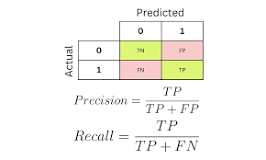

In [17]:
#linear correlation is expected of a plot between in-sample test and y_pred 

ax = sns.scatterplot(x=EN_pred_train2, y= Y_traintest.iloc[:-2])
ax.set(xlabel='predicted values', ylabel='target values',title="Predicted vs Actual Responses")

[Text(0.5, 0, 'predicted values'),
 Text(0, 0.5, 'target values'),
 Text(0.5, 1.0, 'Predicted vs Actual Responses')]

In [18]:
#notice that this shape is unconventional. it should have a gradient of +1 and it is showing -1 now.

In [19]:
Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, index = X_selected_df.index)

In [20]:
X_selected_df

x19       x32       x83       x96       x97       x98  \
Date                                                                     
2004-11-17  0.010314  0.010325  0.183721  0.183925  0.181668  0.179650   
2004-11-18 -0.324097 -0.326023 -5.599323 -5.632592 -5.713201 -5.783385   
2004-11-19 -0.055237 -0.054293 -0.983757 -0.966938 -0.963866 -1.003046   
2004-11-22 -0.016223 -0.016569 -0.282945 -0.288982 -0.289303 -0.289235   
2004-11-23  0.167661  0.165027  2.942852  2.896619  2.913830  3.011720   
...              ...       ...       ...       ...       ...       ...   
2023-10-23 -0.054195 -0.054243 -0.993806 -0.994697 -0.995606 -0.979085   
2023-10-24 -0.261970 -0.268232 -4.762470 -4.876307 -4.751816 -4.858158   
2023-10-25  0.025114  0.025488  0.461117  0.467982  0.455495  0.457124   
2023-10-26  0.079485  0.078525  1.475377  1.457562  1.458868  1.445027   
2023-10-27  0.448408  0.440834  8.291855  8.151798  8.346649  8.048878   

                x139      x140      x141      x142  
Date                                                
2004-11-17  0.184130  0.181870  0.179849  0.179638  
2004-11-18 -5.666058 -5.747147 -5.817747 -5.829395  
2004-11-19 -0.950406 -0.947386 -0.985897 -0.944376  
2004-11-22 -0.295148 -0.295476 -0.295406 -0.295805  
2004-11-23  2.851112  2.868053  2.964405  2.885093  
...              ...       ...       ...       ...  
2023-10-23 -0.995588 -0.996498 -0.979962 -0.997409  
2023-10-24 -4.992864 -4.865398 -4.974282 -4.741186  
2023-10-25  0.474950  0.462276  0.463930  0.449941  
2023-10-26  1.439963  1.441253  1.427579  1.442544  
2023-10-27  8.014106  8.205666  7.912925  8.401805  

[4769 rows x 10 columns]

In [21]:
X_traintest3 = X.copy()
X_traintest3["signal"] = Y_pred_logistic2_df
X_traintest3["signal"].iloc[:13] = 0

In [22]:
X_traintest3["signal"]

Date
2004-11-01    0.0
2004-11-02    0.0
2004-11-03    0.0
2004-11-04    0.0
2004-11-05    0.0
             ... 
2023-10-25    1.0
2023-10-26    1.0
2023-10-27    0.0
2023-10-30    NaN
2023-10-31    NaN
Name: signal, Length: 4783, dtype: float64

In [23]:
X_traintest3

10years futures     Volume     SPY_3     SPY_6    SPY_12  \
Date                                                                   
2004-11-01         1.408545  17.418857       NaN       NaN       NaN   
2004-11-02         1.404871  17.844605       NaN       NaN       NaN   
2004-11-03         1.403643  18.158799       NaN       NaN       NaN   
2004-11-04         1.403151  17.829193  0.005892       NaN       NaN   
2004-11-05         1.431746  17.963194 -0.013966       NaN       NaN   
...                     ...        ...       ...       ...       ...   
2023-10-25         1.599993  18.361177 -0.010312  0.001368 -0.017238   
2023-10-26         1.577947  18.561805 -0.012054  0.004282 -0.008631   
2023-10-27         1.577947  18.491770  0.026341  0.024249  0.018000   
2023-10-30         1.584120  18.276380  0.018308  0.007995  0.011254   
2023-10-31         1.584120  18.193343       NaN       NaN       NaN   

             Volume_3   Volume_6  Volume_12  signal  
Date                                                 
2004-11-01        NaN        NaN        NaN     0.0  
2004-11-02        NaN        NaN        NaN     0.0  
2004-11-03        NaN        NaN        NaN     0.0  
2004-11-04  17.418857        NaN        NaN     0.0  
2004-11-05  17.844605        NaN        NaN     0.0  
...               ...        ...        ...     ...  
2023-10-25  18.634548  18.137319  18.202206     1.0  
2023-10-26  18.337681  18.354111  18.179975     1.0  
2023-10-27  18.179427  18.613967  17.949904     0.0  
2023-10-30  18.361177  18.634548  18.211862     NaN  
2023-10-31  18.561805  18.337681  18.370893     NaN  

[4783 rows x 9 columns]

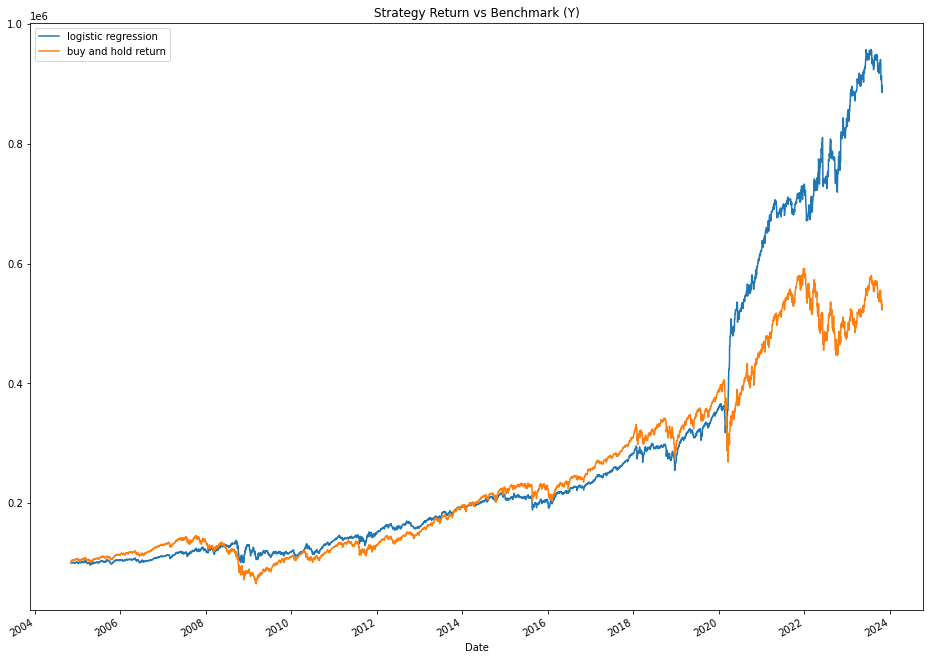

In [24]:
X_traintest3["strategy_return"] = X_traintest3["signal"].shift(1) * Y
fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])
#((X_traintest3["strategy_return"] + 1).cumprod() * capital).plot(ax=ax, label = "logistic regression")
(X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")
#((1+Y).cumprod() * capital).plot(ax=ax, label = "simple return")
(Y.cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

# Add legend
ax.legend()

# Add title
ax.set_title('Strategy Return vs Benchmark (Y)')

# Show the plot
plt.show()
#capital * (1 + X_traintest3["strategy_return"]).cumprod().plot(figsize=[16,12])

In [25]:
cumu_ret = X_traintest3["strategy_return"].cumsum().apply(np.exp).iloc[-4]

In [26]:
X_traintest3["strategy_return"].cumsum().apply(np.exp)

Date
2004-11-01         NaN
2004-11-02    1.000000
2004-11-03    1.000000
2004-11-04    1.000000
2004-11-05    1.000000
                ...   
2023-10-25    8.896840
2023-10-26    8.856513
2023-10-27    8.962399
2023-10-30    8.962399
2023-10-31         NaN
Name: strategy_return, Length: 4783, dtype: float64

In [27]:
cumu_ret

8.85651274884138

In [28]:
X_traintest3["strategy_return"].cumsum().apply(np.exp)

Date
2004-11-01         NaN
2004-11-02    1.000000
2004-11-03    1.000000
2004-11-04    1.000000
2004-11-05    1.000000
                ...   
2023-10-25    8.896840
2023-10-26    8.856513
2023-10-27    8.962399
2023-10-30    8.962399
2023-10-31         NaN
Name: strategy_return, Length: 4783, dtype: float64

In [29]:
X_traintest3["signal"].value_counts()

signal
1.0    3217
0.0    1564
Name: count, dtype: int64

In [30]:
#what if we can short?

In [31]:
signal = X_traintest3["signal"].copy()
short_signal = (signal == 0) * -1 
signals = short_signal + signal

signals.iloc[:12] = 0
signals.value_counts()
#X_traintest3["signal"].iloc[:12] = 0
#X_traintest3["signal"].value_counts()


signal
 1.0    3217
-1.0    1552
 0.0      12
Name: count, dtype: int64

In [32]:
X_traintest3_copy = X_traintest3.copy()
X_traintest3_copy["signal"] = signals

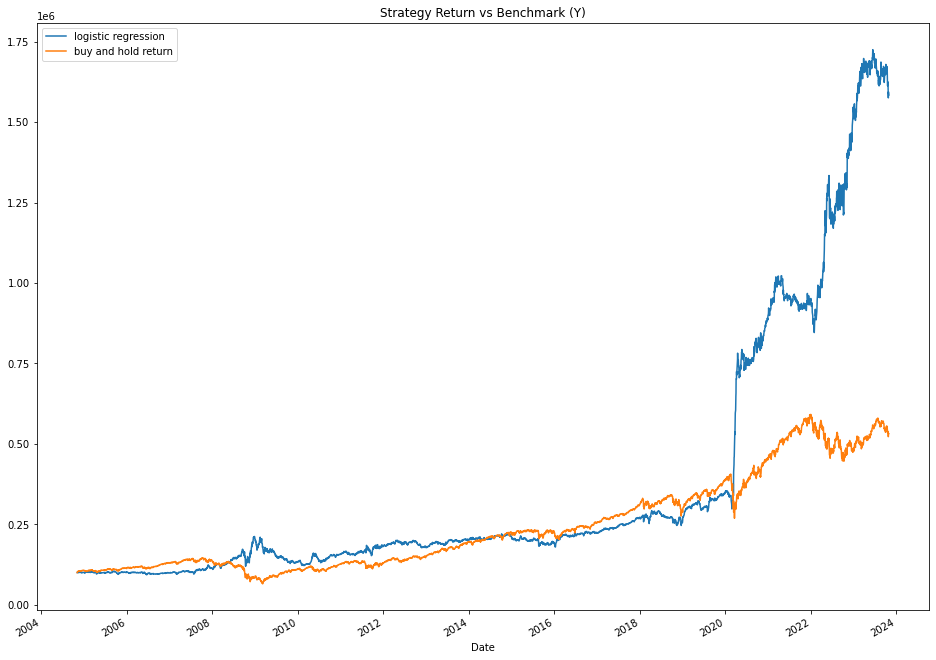

In [33]:
X_traintest3["strategy_return"] = X_traintest3_copy["signal"].shift(1) * Y

fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

(X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")

(Y.cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

# Add legend
ax.legend()

# Add title
ax.set_title('Strategy Return vs Benchmark (Y)')

# Show the plot
plt.show()


In [34]:
#cumu_ret_w_short = ((X_traintest3["strategy_return"] + 1).cumprod() * capital).iloc[-3]

In [35]:
cumu_ret_w_short = X_traintest3["strategy_return"].cumsum().apply(np.exp).iloc[-4]
X_traintest3["strategy_return"].cumsum().apply(np.exp)

Date
2004-11-01          NaN
2004-11-02     1.000000
2004-11-03     1.000000
2004-11-04     1.000000
2004-11-05     1.000000
                ...    
2023-10-25    15.825766
2023-10-26    15.754032
2023-10-27    15.942384
2023-10-30    15.842886
2023-10-31          NaN
Name: strategy_return, Length: 4783, dtype: float64

In [36]:
X_traintest3["strategy_return"].cumsum().apply(np.exp)

Date
2004-11-01          NaN
2004-11-02     1.000000
2004-11-03     1.000000
2004-11-04     1.000000
2004-11-05     1.000000
                ...    
2023-10-25    15.825766
2023-10-26    15.754032
2023-10-27    15.942384
2023-10-30    15.842886
2023-10-31          NaN
Name: strategy_return, Length: 4783, dtype: float64

In [37]:
cumu_ret_w_short

15.75403182648023

In [38]:
(cumu_ret_w_short - cumu_ret)/ max(cumu_ret_w_short, cumu_ret)

0.43782564067473356

In [39]:
(cumu_ret_w_short - cumu_ret)/ cumu_ret

0.77880755927791

# with optimization of the decision threshold value and best k of feature engineering and alpha in elastic net

In [40]:
X_traintest

10years futures     Volume     SPY_3     SPY_6    SPY_12  \
Date                                                                   
2004-11-17         1.421662  17.813601 -0.001105  0.000579  0.000997   
2004-11-18         1.415125  17.276683 -0.003994 -0.018759 -0.023695   
2004-11-19         1.434132  17.809602 -0.001163 -0.003102 -0.008804   
2004-11-22         1.426716  17.441456  0.000175 -0.000930 -0.004720   
2004-11-23         1.431268  17.552437  0.013546  0.009552  0.003817   
...                     ...        ...       ...       ...       ...   
2023-10-25         1.599993  18.361177 -0.010312  0.001368 -0.017238   
2023-10-26         1.577947  18.561805 -0.012054  0.004282 -0.008631   
2023-10-27         1.577947  18.491770  0.026341  0.024249  0.018000   
2023-10-30         1.584120  18.276380  0.018308  0.007995  0.011254   
2023-10-31         1.584120  18.193343  0.018308  0.007995  0.011254   

             Volume_3   Volume_6  Volume_12  
Date                                         
2004-11-17  17.833401  17.614546  17.418857  
2004-11-18  17.379334  17.628054  17.844605  
2004-11-19  17.505107  17.449490  18.158799  
2004-11-22  17.813601  17.833401  17.829193  
2004-11-23  17.276683  17.379334  17.963194  
...               ...        ...        ...  
2023-10-25  18.634548  18.137319  18.202206  
2023-10-26  18.337681  18.354111  18.179975  
2023-10-27  18.179427  18.613967  17.949904  
2023-10-30  18.361177  18.634548  18.211862  
2023-10-31  18.561805  18.337681  18.370893  

[4771 rows x 8 columns]

In [41]:
#transform X_selected into dataframe

X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = X_traintest.iloc[:-2].index)
X_selected_df

x19       x32       x83       x96       x97       x98  \
Date                                                                     
2004-11-17  0.010314  0.010325  0.183721  0.183925  0.181668  0.179650   
2004-11-18 -0.324097 -0.326023 -5.599323 -5.632592 -5.713201 -5.783385   
2004-11-19 -0.055237 -0.054293 -0.983757 -0.966938 -0.963866 -1.003046   
2004-11-22 -0.016223 -0.016569 -0.282945 -0.288982 -0.289303 -0.289235   
2004-11-23  0.167661  0.165027  2.942852  2.896619  2.913830  3.011720   
...              ...       ...       ...       ...       ...       ...   
2023-10-23 -0.054195 -0.054243 -0.993806 -0.994697 -0.995606 -0.979085   
2023-10-24 -0.261970 -0.268232 -4.762470 -4.876307 -4.751816 -4.858158   
2023-10-25  0.025114  0.025488  0.461117  0.467982  0.455495  0.457124   
2023-10-26  0.079485  0.078525  1.475377  1.457562  1.458868  1.445027   
2023-10-27  0.448408  0.440834  8.291855  8.151798  8.346649  8.048878   

                x139      x140      x141      x142  
Date                                                
2004-11-17  0.184130  0.181870  0.179849  0.179638  
2004-11-18 -5.666058 -5.747147 -5.817747 -5.829395  
2004-11-19 -0.950406 -0.947386 -0.985897 -0.944376  
2004-11-22 -0.295148 -0.295476 -0.295406 -0.295805  
2004-11-23  2.851112  2.868053  2.964405  2.885093  
...              ...       ...       ...       ...  
2023-10-23 -0.995588 -0.996498 -0.979962 -0.997409  
2023-10-24 -4.992864 -4.865398 -4.974282 -4.741186  
2023-10-25  0.474950  0.462276  0.463930  0.449941  
2023-10-26  1.439963  1.441253  1.427579  1.442544  
2023-10-27  8.014106  8.205666  7.912925  8.401805  

[4769 rows x 10 columns]

In [185]:
#Feature Engineering

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

# poly = PolynomialFeatures(degree=3)

# index_ = Y_traintest.shift(-1).dropna().index 

# X_poly = poly.fit_transform(X_traintest.loc[index_])


# from sklearn.feature_selection import SelectKBest, f_regression
# #(R-squared / (1 - R-squared)) * ((n - k - 1) / k)

# selector = SelectKBest(score_func=f_regression, k=10) #marginal improvement from when k = 8. big improvement from k = 5

# #we are shifting the Y values because we need to train the model for a 1 day look ahead
# X_selected = selector.fit_transform(X_poly, Y_traintest.shift(-1).loc[index_]) #Y_traintest_binary

# X_columns = selector.get_feature_names_out()

# #transform X_selected into dataframe

# X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = X_traintest.iloc[:-2].index)

# #initiate dictionary to hold data from df.loc[:year]
# df_dict = {}
# columns = X_selected_df.columns 
# X_selected_df = X_selected_df.ffill()




#initiate dictionary to hold data from df.loc[:year]
df_dict = {}

years_in_data = pd.unique(X_selected_df.index.year)

for year_ in years_in_data:
    
    #dont need mask because our data are complete but lets do it anyway for completeness of code
    mask = X_traintest.columns[X_traintest.apply(lambda col: col.loc[X_traintest.index.year == year_].isna().mean() < 0.3)]
    
    X_traintest_to_year = X_traintest.loc[:str(year_), mask].copy()
    
    
    #Feature scaling, consideration of not removing mean so that the values wont go into negative
#     X_traintest_to_year =\
#     (
#         X_traintest_to_year
#         /
#         X_traintest_to_year.max()
#     )
    
    Y_traintest_to_year = Y_traintest.loc[:str(year_)]
    
    poly = PolynomialFeatures(degree=3)
    
    #we are shifting the Y values because we need to train the model for a 1 day look ahead
    index_ =\
    (Y_traintest_to_year
     .shift(-1)
     .dropna()
     .index 
    )

    X_poly = poly.fit_transform(X_traintest_to_year.loc[index_])  
    #(R-squared / (1 - R-squared)) * ((n - k - 1) / k)

    selector = SelectKBest(score_func=f_regression, k=10) 
    
    X_selected = selector.fit_transform(X_poly, Y_traintest.shift(-1).loc[index_]) #Y_traintest_binary

    X_columns = selector.get_feature_names_out()

    #transform X_selected into dataframe

    X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = index_)

    #make sure no missing values
    X_selected_df = X_selected_df.ffill()
    
    #columns = X_selected_df.columns 
    
    df_dict[year_] = X_selected_df

In [186]:
df_dict[2004]

x18         x23       x28         x59       x82       x91  \
Date                                                                         
2004-11-17 -0.019693  310.292565 -0.019473  441.130999 -0.350802 -0.351192   
2004-11-18 -0.069001  308.295587 -0.070404  436.276721 -1.192106 -1.199189   
2004-11-19 -0.020711  323.400981 -0.020292  463.799603 -0.368850 -0.362544   
2004-11-22  0.003059  310.967071  0.003128  443.661778  0.053353  0.054491   
2004-11-23  0.237763  315.297826  0.235418  451.275603  4.173316  4.107752   
2004-11-24 -0.094955  298.341043 -0.096597  427.789247 -1.633937 -1.691111   
2004-11-26 -0.100935  291.618620 -0.108605  421.123952 -1.671032 -1.760450   
2004-11-29 -0.030271  316.139927 -0.029162  463.324411 -0.542882 -0.531334   
2004-11-30  0.214697  310.577333  0.214829  457.173931  3.821319  3.694400   
2004-12-01  0.095912  316.105897  0.094375  466.542754  1.700085  1.587874   
2004-12-02 -0.024169  311.308649 -0.023683  461.023968 -0.432927 -0.433443   
2004-12-03 -0.206091  309.992966 -0.200258  449.990075 -3.649608 -3.668142   
2004-12-06 -0.176477  308.405843 -0.168757  445.511736 -3.055337 -3.128144   
2004-12-07  0.115411  306.966255  0.116491  442.489579  2.050592  2.067317   
2004-12-08  0.068021  313.401144  0.068799  444.793138  1.196991  1.204569   
2004-12-09  0.185723  312.640149  0.183654  445.748374  3.329100  3.215405   
2004-12-10  0.050447  310.382102  0.051101  442.155788  0.892060  0.896324   
2004-12-13 -0.000827  300.567280 -0.000839  427.812220 -0.014447 -0.014554   
2004-12-14 -0.004575  290.404677 -0.004515  412.014988 -0.080246 -0.082002   
2004-12-15 -0.163475  316.699180 -0.164478  444.999138 -2.886839 -2.890745   
2004-12-16 -0.180706  316.101174 -0.179052  452.500946 -3.209306 -3.156429   
2004-12-17 -0.008933  320.385376 -0.008859  460.313610 -0.161459 -0.156692   
2004-12-20  0.145786  316.508731  0.145897  454.141405  2.575983  2.574467   
2004-12-21  0.157531  306.624084  0.158917  437.686365  2.727622  2.797719   
2004-12-22  0.008543  298.916951  0.008680  429.042268  0.147507  0.154421   
2004-12-23 -0.166222  303.114566 -0.172062  436.291305 -2.835732 -2.937083   
2004-12-27  0.052598  302.934983  0.054263  441.230794  0.905471  0.910732   
2004-12-28  0.012535  304.175357  0.013352  443.037423  0.212707  0.216421   
2004-12-29  0.002969  299.476204  0.003098  438.348789  0.050289  0.050658   
2004-12-30 -0.128328  294.561974 -0.131761  427.106951 -2.164080 -2.209143   

                 x92      x124      x125      x127  
Date                                                
2004-11-17 -0.346882 -0.351582 -0.347268 -0.343006  
2004-11-18 -1.216350 -1.206314 -1.223577 -1.241088  
2004-11-19 -0.361392 -0.356346 -0.355213 -0.354085  
2004-11-22  0.054552  0.055654  0.055716  0.055778  
2004-11-23  4.132159  4.043218  4.067241  4.091407  
2004-11-24 -1.662197 -1.750285 -1.720360 -1.690946  
2004-11-26 -1.798012 -1.854653 -1.894225 -1.934642  
2004-11-29 -0.522987 -0.520032 -0.511862 -0.503821  
2004-11-30  3.823671  3.571696  3.696674  3.826024  
2004-12-01  1.672842  1.483069  1.562429  1.646036  
2004-12-02 -0.424223 -0.433959 -0.424728 -0.415694  
2004-12-03 -3.546310 -3.686770 -3.564320 -3.445936  
2004-12-06 -2.921676 -3.202686 -2.991298 -2.793862  
2004-12-07  2.069779  2.084179  2.086661  2.089146  
2004-12-08  1.210686  1.212194  1.218350  1.224538  
2004-12-09  3.292026  3.105593  3.179597  3.255365  
2004-12-10  0.903634  0.900608  0.907954  0.915359  
2004-12-13 -0.014647 -0.014663 -0.014756 -0.014849  
2004-12-14 -0.079202 -0.083797 -0.080935 -0.078171  
2004-12-15 -2.904563 -2.894657 -2.908494 -2.922397  
2004-12-16 -3.179936 -3.104425 -3.127543 -3.150835  
2004-12-17 -0.160122 -0.152066 -0.155394 -0.158795  
2004-12-20  2.577950  2.572951  2.576433  2.579920  
2004-12-21  2.751624  2.869617  2.822338  2.775837  
2004-12-22  0.149862  0.161659  0.156887  0.152255  
2004-12-23 -2.935355 -3.042057 -3.040267 -3.038477  
2004-12-27  0.934137  0.916024  0.93

In [212]:
# Model Specification

penalty_ = 0.0

def fit_and_predict(df_dict,Y_traintest_series,penalty_):
    params_dict = {}
    
    for year_ in years_in_data:
        
        X_index = df_dict[year_].index 
        Y_traintest_series_fraction = Y_traintest_series.loc[X_index]

        elastic_net = ElasticNet(alpha=0.01, l1_ratio=penalty_)

        elastic_net.fit(df_dict[year_], Y_traintest_series_fraction)
        print("intercept is {:.3f} and coefficients are {}".format(elastic_net.intercept_, elastic_net.coef_))

        EN_pred_train2 = elastic_net.predict(df_dict[year_])


        #continuous predictions are turned into binary signal or 1 and 0 
        Y_pred_binary2 = (EN_pred_train2 > 0.0).astype(int)


        logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver = "saga")
        logreg_sk2.fit(df_dict[year_], Y_pred_binary2)
        print("intercept is {:.3f} and coefficients are {}".format(logreg_sk2.intercept_[0], logreg_sk2.coef_[0]))
        

        Y_pred_logistic2 = logreg_sk2.predict(df_dict[year_])

        Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, index = df_dict[year_].index)

        params_dict[f"EN_pred_{year_}"] = EN_pred_train2
        params_dict[f"binary_pred_{year_}"] = Y_pred_binary2
        params_dict[f"logistic_pred_{year_}"] = Y_pred_logistic2_df

        params_dict[f"Accuracy_{year_}"] = metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2)
        params_dict[f"Precision_{year_}"] = metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
        params_dict[f"Recall_{year_}"] = metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
                                                            
        print("Name of features used: {}".format(elastic_net.feature_names_in_))
        print(" ")
        print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2))
        print(" ")
        print("Precision :", metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        print(" ")
        print("Recall :", metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        
        #long only
        
        
        X_traintest3 = X.copy()
        X_traintest3["signal"] = Y_pred_logistic2_df
        X_traintest3["signal"].iloc[:12] = 0
        
#             X_traintest3 = df_dict[year_].copy()
#             X_traintest3["signal"] = Y_pred_logistic2_df
#             X_traintest3["signal"].iloc[:13] = 0

#             signal = X_traintest3["signal"].copy()
#             short_signal = (signal == 0) * -1 
#             signals = short_signal + signal
#             signals.iloc[:12] = 0

#             X_traintest3_copy = X_traintest3.copy()
#             X_traintest3_copy["signal"] = signals
        

        X_traintest3["strategy_return"] = X_traintest3["signal"].shift(1) * Y
        fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

        (X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")

        (Y.loc[X_index].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

        ax.legend()
        ax.set_title('Strategy Return vs Benchmark (Y)')
        plt.show()
    
    return params_dict, X_traintest3

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e-04, tolerance: 6.962e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is -0.039 and coefficients are [-1.53986828e-04  6.22120745e-05 -2.31663326e-04  4.58994577e-05
  2.23744208e-03  9.05115868e-04  3.67869168e-04 -1.09060967e-03
 -9.85240910e-04 -9.58640832e-04]
intercept is -0.000 and coefficients are [ 0.00074314 -0.00467151  0.00074598  0.00393412  0.01296995  0.01301705
  0.01301489  0.01307339  0.01306636  0.01306907]
Name of features used: ['x18' 'x23' 'x28' 'x59' 'x82' 'x91' 'x92' 'x124' 'x125' 'x127']
 
Accuracy : 0.6333333333333333
 
Precision : 0.6333333333333333
 
Recall : 1.0


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.728e-03, tolerance: 1.158e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [ 6.67126465e-06  9.11025789e-05 -1.20604591e-05  1.19314539e-04
 -1.39242603e-04  1.35781887e-03 -1.66404450e-07 -1.12067667e-07
 -8.92018464e-08 -1.57971559e-03]
intercept is 4.919 and coefficients are [-8.09766193e-03 -1.07015836e-01 -1.13284194e-02 -1.38298915e-01
 -1.49868442e-01 -1.83295057e+00  2.59642706e-06 -1.50824277e-07
 -1.25057769e-06 -1.97451163e+00]
Name of features used: ['x13' 'x36' 'x49' 'x56' 'x72' 'x100' 'x109' 'x110' 'x115' 'x149']
 
Accuracy : 0.34397163120567376
 
Precision : 0.42487046632124353
 
Recall : 0.5256410256410257


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.053e-02, tolerance: 2.124e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is -0.008 and coefficients are [-3.61079994e-04 -2.53978952e-04  2.72803211e-04 -2.00306172e-07
 -1.24125518e-07 -1.45667659e-07 -1.39321506e-07  1.57679500e-05
 -3.87072757e-07 -1.38415589e-05]
intercept is -0.000 and coefficients are [-9.63039662e-05 -6.97398407e-04 -1.04266718e-03 -3.58951686e-11
 -6.73477443e-12  2.05767459e-11  2.00631659e-11  5.60725460e-03
 -4.87371604e-03 -3.88321839e-04]
Name of features used: ['x6' 'x39' 'x41' 'x109' 'x110' 'x111' 'x115' 'x155' 'x156' 'x157']
 
Accuracy : 0.551594746716698
 
Precision : 0.5551330798479087
 
Recall : 0.9831649831649831


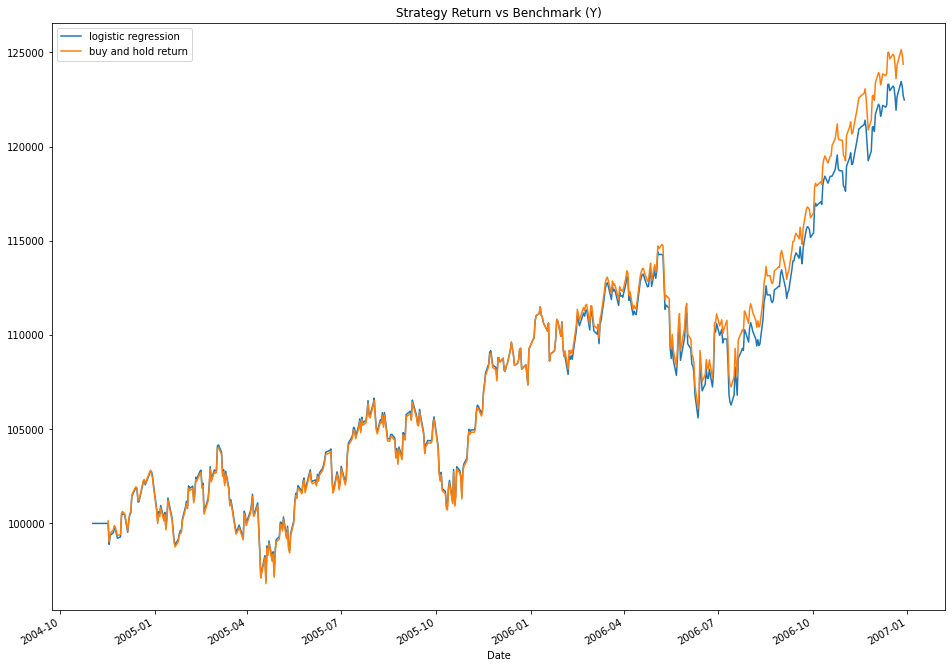

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.298e-02, tolerance: 4.655e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [ 1.68459554e-04  5.29262895e-05 -1.10279816e-04  3.45789154e-04
 -2.37731905e-07 -1.89037918e-07  4.19622817e-04 -1.09968804e-03
 -1.58251759e-03  1.68864426e-03]
intercept is 3.796 and coefficients are [-2.44182252e-02 -2.76496261e-02 -3.56286402e-02 -4.66376773e-01
 -1.52075938e-07 -3.13300843e-07 -4.05462451e-01 -5.01172211e-01
 -5.96872413e-01 -3.69972137e-01]
Name of features used: ['x56' 'x72' 'x73' 'x101' 'x111' 'x116' 'x149' 'x150' 'x152' 'x153']
 
Accuracy : 0.3635204081632653
 
Precision : 0.44405594405594406
 
Recall : 0.5839080459770115


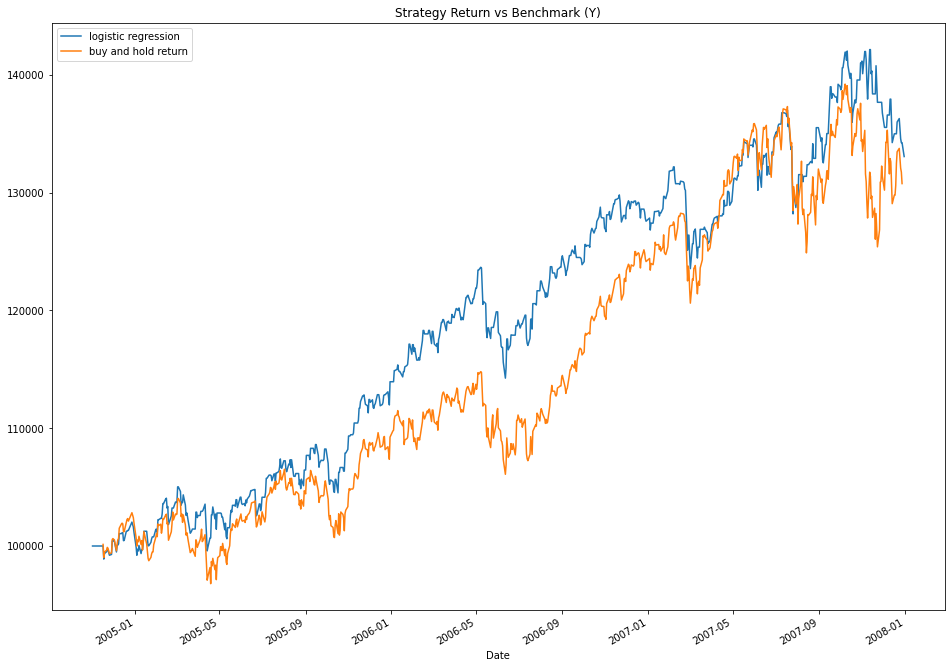

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.076e-01, tolerance: 2.176e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.000 and coefficients are [-0.00030633 -0.00039695 -0.00011281 -0.00606564 -0.00163651 -0.00614223
 -0.00614006 -0.00612271 -0.00166412 -0.00166645]
intercept is 0.579 and coefficients are [-0.13074224 -0.17619432 -0.08870684 -2.52941007 -1.28982782 -2.53195078
 -2.52616507 -2.52385238 -1.29140703 -1.28303122]
Name of features used: ['x30' 'x66' 'x67' 'x94' 'x95' 'x132' 'x133' 'x134' 'x136' 'x138']
 
Accuracy : 0.5438765670202508
 
Precision : 0.5436507936507936
 
Recall : 0.9768270944741533


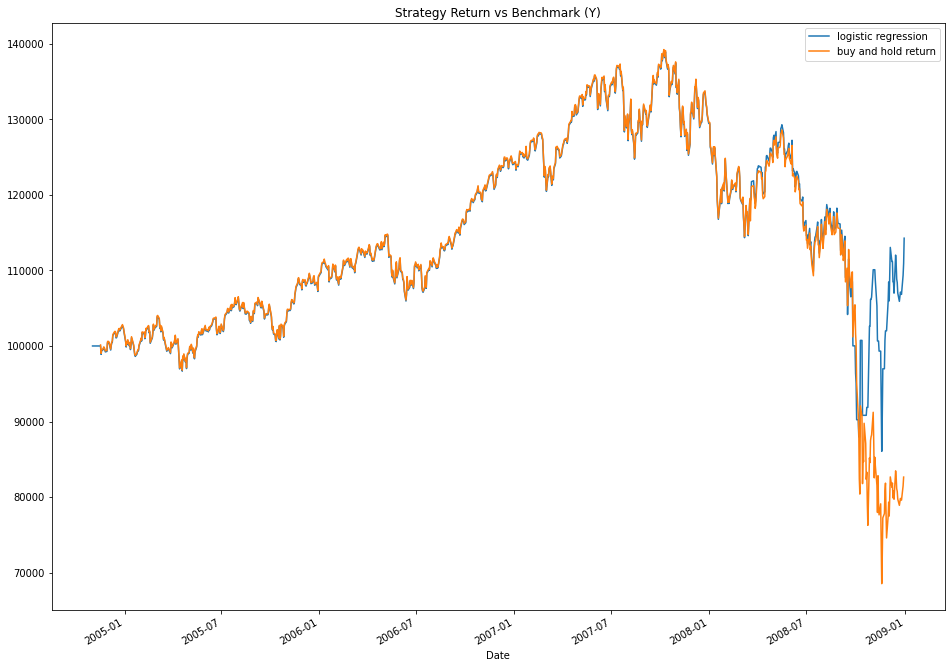

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.416e-01, tolerance: 2.878e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00024781  0.00035246 -0.00032776 -0.00488935 -0.00496462 -0.00497963
 -0.00495017 -0.00061342  0.00015833  0.00025623]
intercept is 0.926 and coefficients are [-0.00231563 -0.02788675 -0.00295776 -0.04575913 -0.04601625 -0.04622459
 -0.04587697 -0.37824396 -0.36914045 -0.36074775]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150' 'x152']
 
Accuracy : 0.26764934057408846
 
Precision : 0.3416230366492147
 
Recall : 0.3717948717948718


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.578e-01, tolerance: 3.197e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00021352  0.00040914 -0.00028308 -0.00421576 -0.00428112 -0.00429526
 -0.00427058 -0.00091814  0.00029569  0.0004384 ]
intercept is 1.304 and coefficients are [-0.00275508 -0.02734458 -0.00351509 -0.05434814 -0.05462644 -0.05513883
 -0.05446308 -0.36550772 -0.31030727 -0.25468707]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150' 'x152']
 
Accuracy : 0.31343283582089554
 
Precision : 0.39520958083832336
 
Recall : 0.4669811320754717


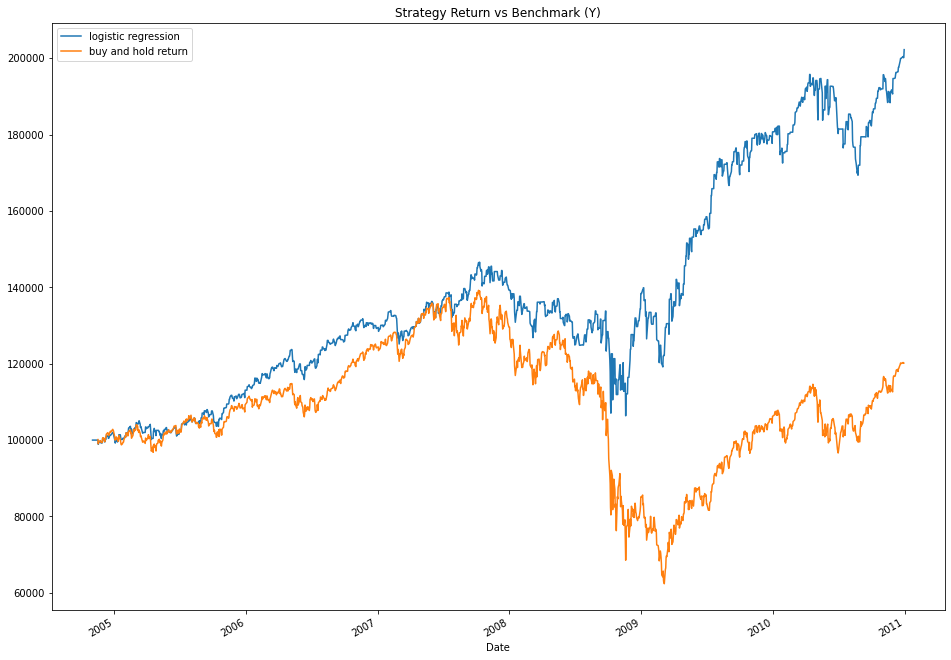

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 3.730e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00018281  0.00035598 -0.00024884 -0.00360712  0.00136459 -0.00367018
 -0.00369249 -0.0036658  -0.00236388  0.00081154]
intercept is 1.533 and coefficients are [-0.0018377  -0.02507951 -0.00218247 -0.03629031 -0.40163951 -0.03647477
 -0.03682683 -0.03624516 -0.46358404 -0.41028133]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.301728945900725
 
Precision : 0.38141592920353984
 
Recall : 0.4380081300813008


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 3.895e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00016699  0.00042793 -0.0002266  -0.00329502  0.00132288 -0.00335128
 -0.00337044 -0.0033455  -0.00242419  0.0009197 ]
intercept is 1.974 and coefficients are [-0.00178986 -0.02280284 -0.00212719 -0.03539478 -0.36703119 -0.0356183
 -0.03593732 -0.03534234 -0.45840029 -0.37719066]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.32305433186490456
 
Precision : 0.40534682080924855
 
Recall : 0.5004460303300624


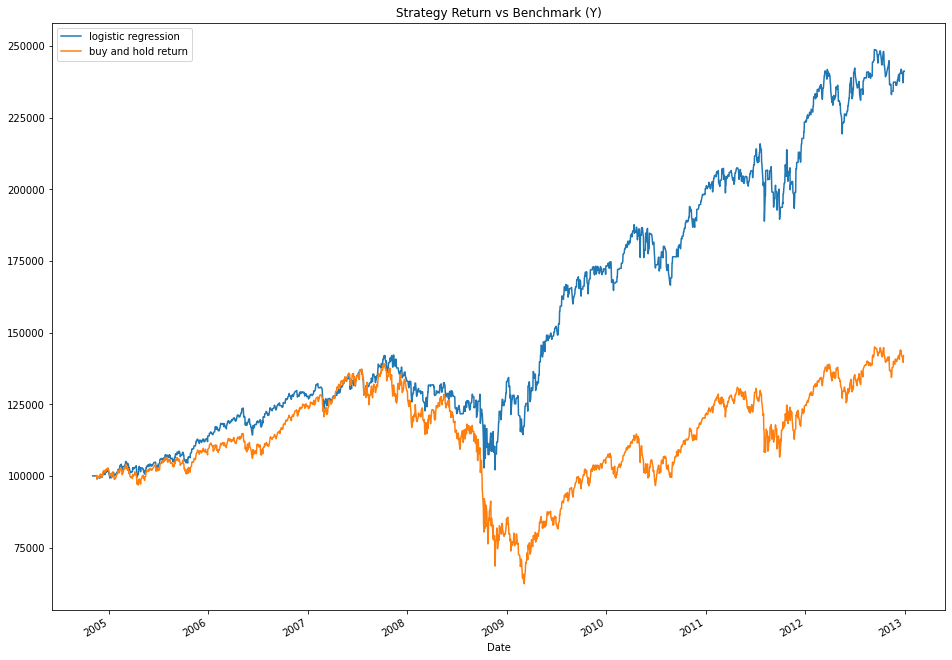

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.983e-01, tolerance: 4.013e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00015361  0.0004419  -0.00020837 -0.00303223  0.0012501  -0.00308253
 -0.0030998  -0.00307669 -0.0022221   0.00079237]
intercept is 2.485 and coefficients are [-0.00166611 -0.01961072 -0.0020087  -0.03293412 -0.34593466 -0.03327179
 -0.03351613 -0.03292496 -0.44983513 -0.36165014]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.34814814814814815
 
Precision : 0.43089921544960774
 
Recall : 0.56353591160221


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e-01, tolerance: 4.139e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00014112 -0.00019171 -0.00067064 -0.00278637  0.00128216 -0.00283254
 -0.00284866 -0.0028276  -0.00215678  0.00076506]
intercept is 2.691 and coefficients are [-0.00157795 -0.00189726 -0.04591524 -0.03125178 -0.3271796  -0.03150078
 -0.03180301 -0.03117953 -0.46569213 -0.34661455]
Name of features used: ['x30' 'x66' 'x72' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.364742834707499
 
Precision : 0.44678609062170704
 
Recall : 0.5988700564971752


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.170e-01, tolerance: 4.379e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00012946 -0.00017532 -0.00056951 -0.0003767  -0.00255354 -0.00259514
 -0.00261248 -0.00259186 -0.00110802  0.00101995]
intercept is 3.157 and coefficients are [-0.0025916  -0.00312403 -0.08714102 -0.07929604 -0.05115102 -0.05158338
 -0.05194514 -0.05099628 -0.78792653 -0.65419945]
Name of features used: ['x30' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.3476241514826724
 
Precision : 0.4292013718765311
 
Recall : 0.5699414443721535


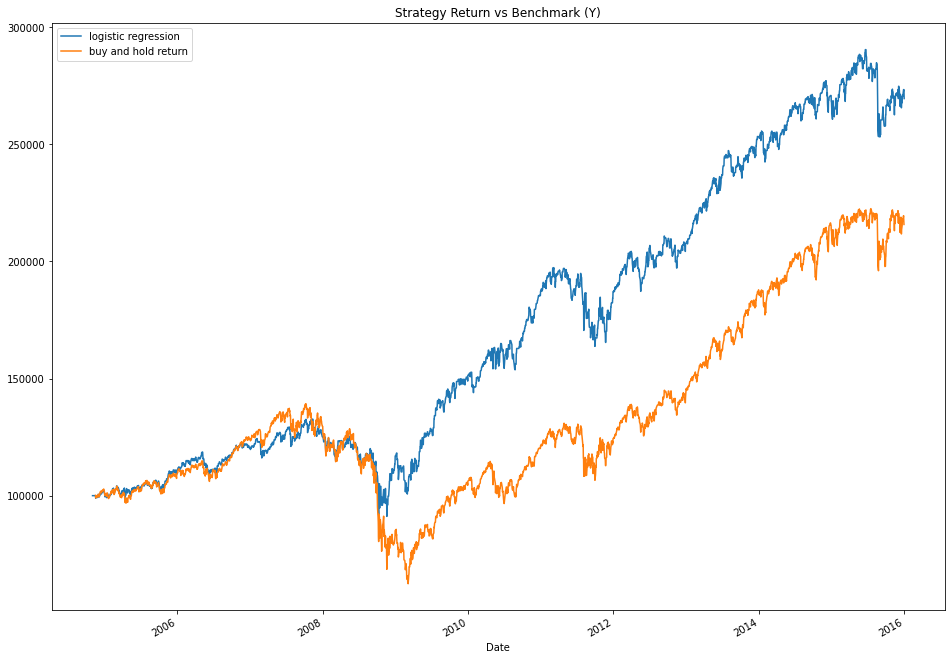

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.255e-01, tolerance: 4.548e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.0001225  -0.00016474 -0.00065571 -0.00047108 -0.00241515 -0.00245298
 -0.00246825 -0.00244905 -0.00108823  0.00101096]
intercept is 3.343 and coefficients are [-0.00262527 -0.00319917 -0.13314998 -0.1248734  -0.05176704 -0.05222379
 -0.05258069 -0.05166884 -0.76970824 -0.61692318]
Name of features used: ['x30' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.36283185840707965
 
Precision : 0.4409448818897638
 
Recall : 0.6021505376344086


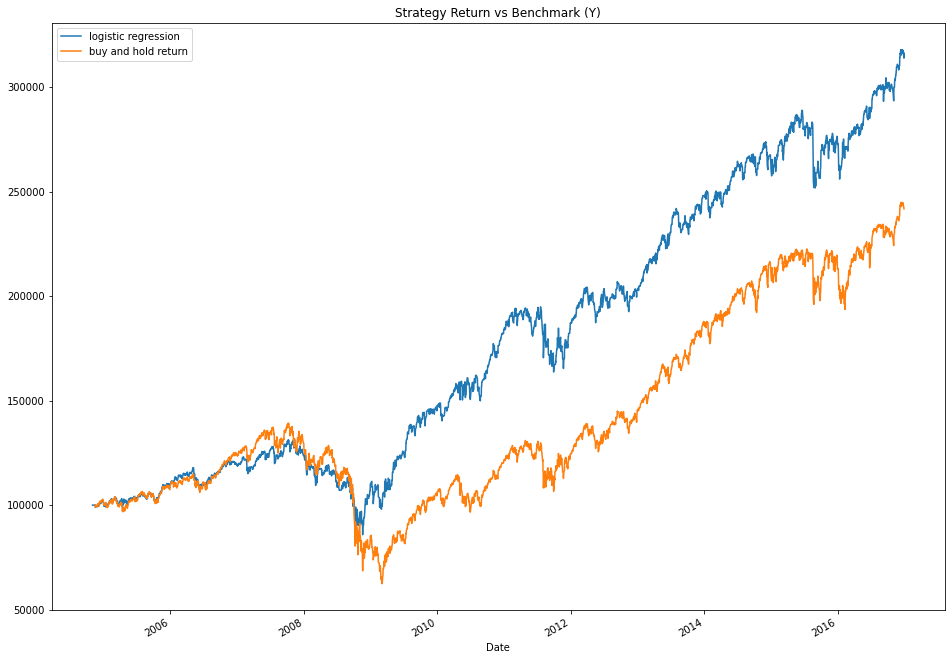

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.278e-01, tolerance: 4.593e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00011521 -0.00015471 -0.00061055 -0.00043669 -0.00227146 -0.00230646
 -0.00232068 -0.00230262 -0.00107693  0.0009938 ]
intercept is 3.757 and coefficients are [-0.00223166 -0.0027575  -0.15227519 -0.1444213  -0.04390071 -0.04446566
 -0.04473689 -0.04387993 -0.78310062 -0.63322773]
Name of features used: ['x30' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.3855239248940036
 
Precision : 0.45865834633385333
 
Recall : 0.647220693450743


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.425e-01, tolerance: 4.883e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-1.06646628e-04 -2.30543451e-05 -1.43873556e-04 -5.21065816e-04
 -2.42845728e-04 -2.10428807e-03 -2.13662914e-03 -2.15170103e-03
 -2.13270393e-03 -9.05935296e-05]
intercept is 4.660 and coefficients are [-0.0043043  -0.2143069  -0.00522853 -0.21323006 -0.21446955 -0.08457433
 -0.08552347 -0.08639738 -0.08449011 -1.91246274]
Name of features used: ['x30' 'x56' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149']
 
Accuracy : 0.37320574162679426
 
Precision : 0.4486846980363097
 
Recall : 0.6210256410256411


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.504e-01, tolerance: 5.041e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-1.02085419e-04 -7.06618153e-05 -1.36610294e-04 -5.34211416e-04
 -2.67353095e-04 -2.01266269e-03 -2.04484141e-03 -2.05829278e-03
 -2.03949340e-03 -8.53818177e-05]
intercept is 5.021 and coefficients are [-0.00422849 -0.27645935 -0.0051017  -0.27513075 -0.27512463 -0.08289889
 -0.08397287 -0.08469166 -0.0830436  -1.75927177]
Name of features used: ['x30' 'x56' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149']
 
Accuracy : 0.3921156373193167
 
Precision : 0.464321608040201
 
Recall : 0.66


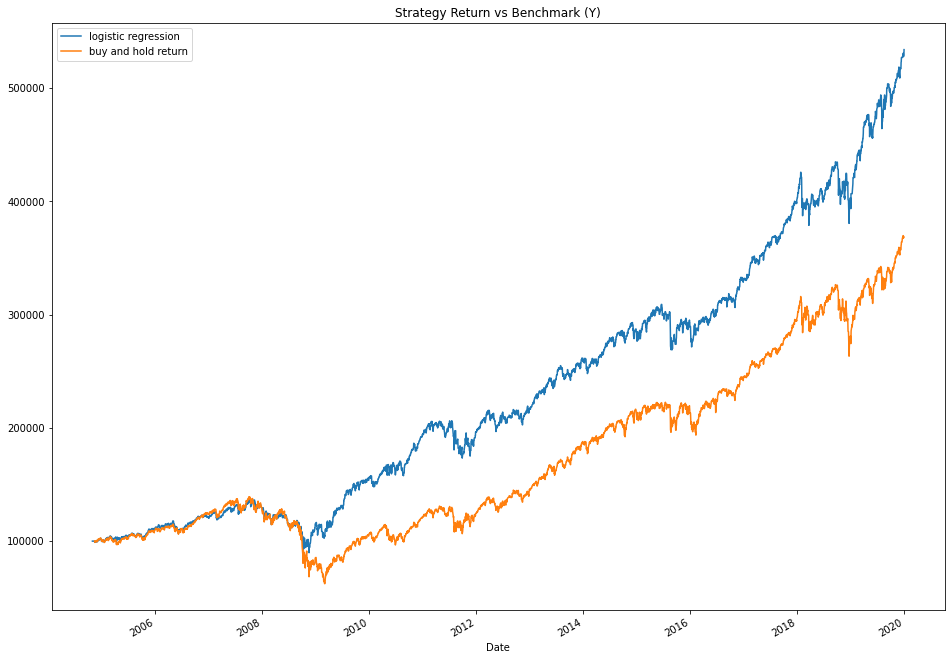

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.017e-01, tolerance: 6.175e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [ 3.75809332e-06  8.75281997e-06 -2.81383815e-03 -2.20319576e-04
  1.12603412e-03  1.64968251e-03 -2.24938499e-03  8.18539920e-04
  1.62998118e-03 -1.57635239e-04]
intercept is 1.730 and coefficients are [-0.00734803 -0.00655605 -0.17133535 -0.15703287 -0.11228999 -0.08614173
 -0.1419576  -0.09747891 -0.07129355 -0.05229874]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.35411532774765897
 
Precision : 0.43558914462384063
 
Recall : 0.5645592163846839


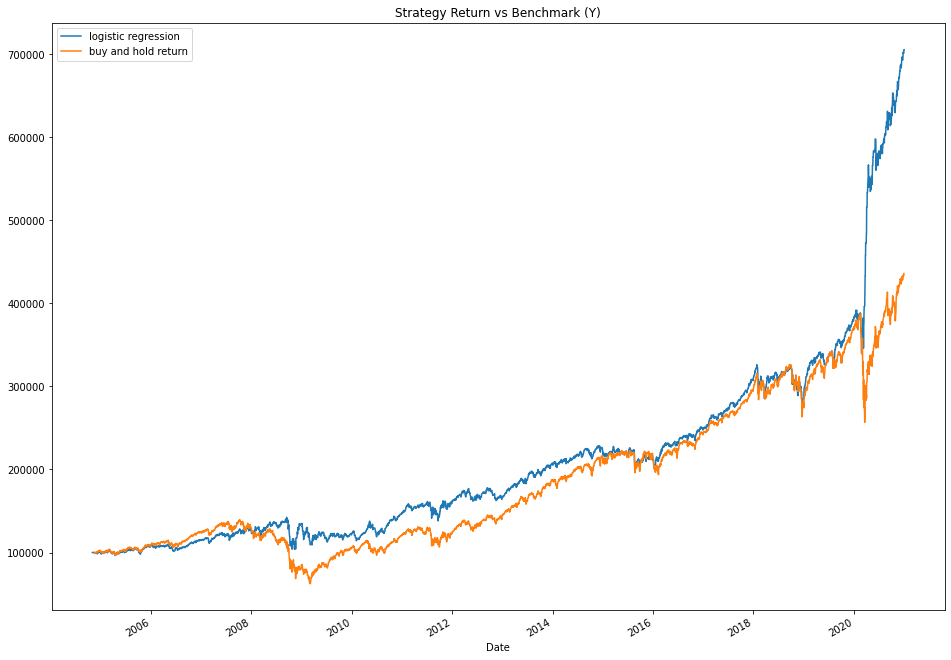

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e-01, tolerance: 6.342e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [ 2.21449575e-05  4.19537399e-05 -2.80474818e-03 -1.56769418e-04
  1.05032127e-03  1.64254146e-03 -2.07990057e-03  7.42913926e-04
  1.62196426e-03 -2.32926881e-04]
intercept is 1.859 and coefficients are [-0.0072337  -0.00626102 -0.17367846 -0.1560506  -0.11158765 -0.07854012
 -0.13777994 -0.09348623 -0.06035144 -0.04877831]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.3654292343387471
 
Precision : 0.4460182562165565
 
Recall : 0.592391304347826


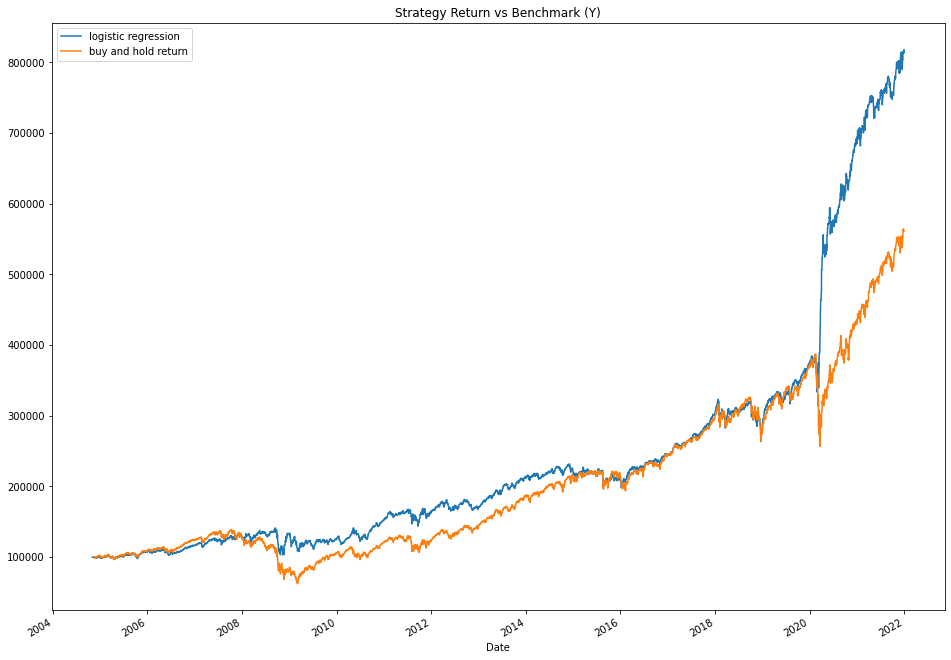

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.400e-01, tolerance: 6.930e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [ 1.31898202e-04  1.67755757e-04 -2.69250859e-03 -5.63010255e-05
  9.27510683e-04  1.65453153e-03 -1.91322175e-03  6.34324222e-04
  1.63878562e-03 -4.05727912e-04]
intercept is 1.819 and coefficients are [-0.00772581 -0.00666369 -0.18024466 -0.16095406 -0.12305926 -0.08243337
 -0.141      -0.10323168 -0.06252556 -0.06508668]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.3488270116202587
 
Precision : 0.4283969465648855
 
Recall : 0.5609756097560976


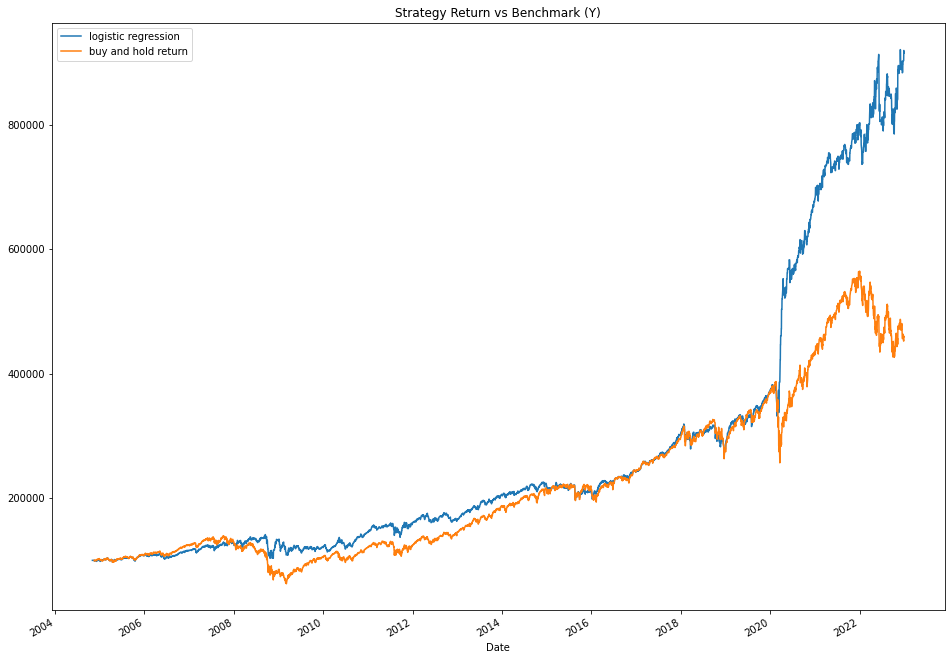

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.475e-01, tolerance: 7.079e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [ 1.55855383e-04  1.95542338e-04 -2.70256801e-03 -4.28460717e-05
  9.12021536e-04  1.65740792e-03 -1.87118546e-03  6.16328385e-04
  1.64124504e-03 -4.22017855e-04]
intercept is 1.872 and coefficients are [-0.00782456 -0.00664484 -0.18414064 -0.16268531 -0.12400417 -0.08197318
 -0.14055226 -0.1020199  -0.0598922  -0.06309758]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.3493394841685888
 
Precision : 0.4284054603543421
 
Recall : 0.5651340996168582


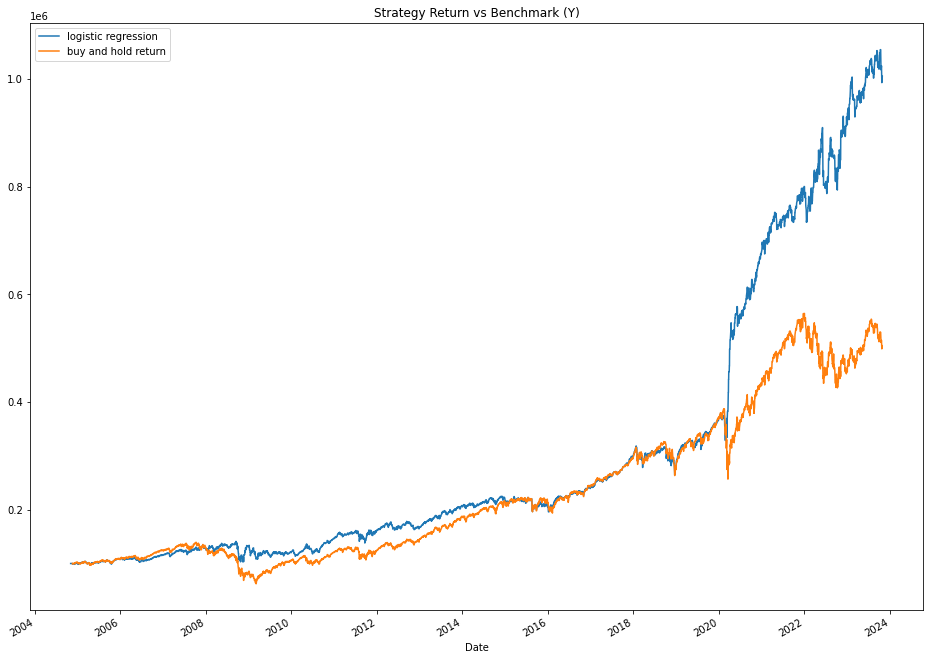

In [213]:
Y_traintest2 = Y_traintest.shift(-1).loc[index_]

params, X_traintest4= fit_and_predict(df_dict,Y_traintest2,penalty_)

In [214]:
(X_traintest4["strategy_return"].cumsum().apply(np.exp))

Date
2004-11-01          NaN
2004-11-02     1.000000
2004-11-03     1.000000
2004-11-04     1.000000
2004-11-05     1.000000
                ...    
2023-10-25     9.974421
2023-10-26     9.929209
2023-10-27    10.047921
2023-10-30    10.047921
2023-10-31          NaN
Name: strategy_return, Length: 4783, dtype: float64

[Text(0.5, 0, 'predicted values'),
 Text(0, 0.5, 'target values'),
 Text(0.5, 1.0, 'Predicted vs Actual Responses')]

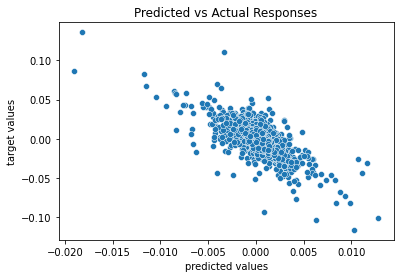

In [215]:
#can turn into a plot function

#linear correlation is expected of a plot between in-sample test and y_pred 
                    #params_dict[]
ax = sns.scatterplot(x=EN_pred_train2, y= Y_traintest.iloc[:-2])
ax.set(xlabel='predicted values', ylabel='target values',title="Predicted vs Actual Responses")

In [216]:
penalty_ = 0.0

def fit_and_predict_w_short(df_dict,Y_traintest_series,penalty_):
    params_dict = {}
    
    for year_ in years_in_data:
        
        X_index = df_dict[year_].index 
        Y_traintest_series_fraction = Y_traintest_series.loc[X_index]

        elastic_net = ElasticNet(alpha=0.02, l1_ratio=penalty_)

        elastic_net.fit(df_dict[year_], Y_traintest_series_fraction)
        print("intercept is {:.3f} and coefficients are {}".format(elastic_net.intercept_, elastic_net.coef_))

        EN_pred_train2 = elastic_net.predict(df_dict[year_])


        #continuous predictions are turned into binary signal or 1 and 0 
        Y_pred_binary2 = (EN_pred_train2 > 0.0).astype(int)


        logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver = "saga")
        logreg_sk2.fit(df_dict[year_], Y_pred_binary2)
        print("intercept is {:.3f} and coefficients are {}".format(logreg_sk2.intercept_[0], logreg_sk2.coef_[0]))
        

        Y_pred_logistic2 = logreg_sk2.predict(df_dict[year_])

        Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, index = df_dict[year_].index)

        params_dict[f"EN_pred_{year_}"] = EN_pred_train2
        params_dict[f"binary_pred_{year_}"] = Y_pred_binary2
        params_dict[f"logistic_pred_{year_}"] = Y_pred_logistic2_df

        params_dict[f"Accuracy_{year_}"] = metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2)
        params_dict[f"Precision_{year_}"] = metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
        params_dict[f"Recall_{year_}"] = metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
                                                            
        print("Name of features used: {}".format(elastic_net.feature_names_in_))
        print(" ")
        print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2))
        print(" ")
        print("Precision :", metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        print(" ")
        print("Recall :", metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        
        #long and short
        
        X_traintest3 = df_dict[year_].copy()
        X_traintest3["signal"] = Y_pred_logistic2_df
        X_traintest3["signal"].iloc[:13] = 0
        
        signal = X_traintest3["signal"].copy()
        short_signal = (signal == 0) * -1 
        signals = short_signal + signal
        signals.iloc[:12] = 0
        
        X_traintest3_copy = X_traintest3.copy()
        X_traintest3_copy["signal"] = signals
        

        X_traintest3["strategy_return"] = X_traintest3_copy["signal"].shift(1) * Y
        fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

        (X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")

        (Y.loc[X_index].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

        ax.legend()
        ax.set_title('Strategy Return vs Benchmark (Y)')
        plt.show()
    
    return params_dict, X_traintest3

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e-04, tolerance: 6.962e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is -0.038 and coefficients are [-7.22584610e-05  5.60370477e-05 -1.21576846e-04  4.77731641e-05
  1.17261740e-03  4.37175785e-04  4.24155415e-04 -4.48560715e-04
 -4.84165927e-04 -6.29191435e-04]
intercept is -0.000 and coefficients are [ 0.00075047 -0.00484938  0.00075337  0.00405903  0.01309835  0.01314641
  0.01314435  0.01320376  0.01319679  0.01319959]
Name of features used: ['x18' 'x23' 'x28' 'x59' 'x82' 'x91' 'x92' 'x124' 'x125' 'x127']
 
Accuracy : 0.6333333333333333
 
Precision : 0.6333333333333333
 
Recall : 1.0


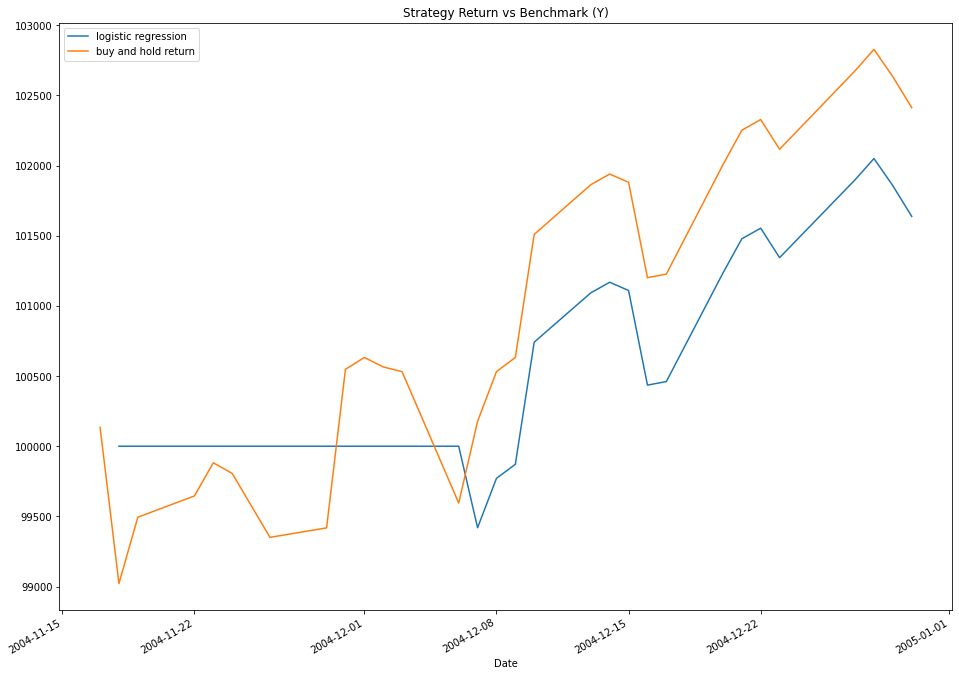

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.732e-03, tolerance: 1.158e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [ 2.97740280e-06  3.91656058e-05 -6.67699806e-06  5.86794378e-05
 -8.05582459e-05  7.38363896e-04 -8.25825978e-08 -5.59224134e-08
 -4.46655906e-08 -9.56140695e-04]
intercept is 5.120 and coefficients are [-8.05469919e-03 -1.06404224e-01 -1.12974613e-02 -1.40538856e-01
 -1.49405200e-01 -1.85935478e+00  2.03423729e-06 -4.31885934e-07
 -1.54555859e-06 -1.96766903e+00]
Name of features used: ['x13' 'x36' 'x49' 'x56' 'x72' 'x100' 'x109' 'x110' 'x115' 'x149']
 
Accuracy : 0.3475177304964539
 
Precision : 0.42783505154639173
 
Recall : 0.532051282051282


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.053e-02, tolerance: 2.124e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is -0.009 and coefficients are [-1.84104745e-04 -2.60284975e-04  2.65346032e-04 -1.00153887e-07
 -6.20594080e-08 -7.28322431e-08 -6.96540857e-08  1.56837843e-05
 -3.85959200e-07 -1.34309401e-05]
intercept is -0.000 and coefficients are [-9.65330736e-05 -6.99518725e-04 -1.04504856e-03 -3.35501915e-11
 -5.30115694e-12  2.08923560e-11  2.11861752e-11  5.60656054e-03
 -4.86518605e-03 -3.96146167e-04]
Name of features used: ['x6' 'x39' 'x41' 'x109' 'x110' 'x111' 'x115' 'x155' 'x156' 'x157']
 
Accuracy : 0.551594746716698
 
Precision : 0.5551330798479087
 
Recall : 0.9831649831649831


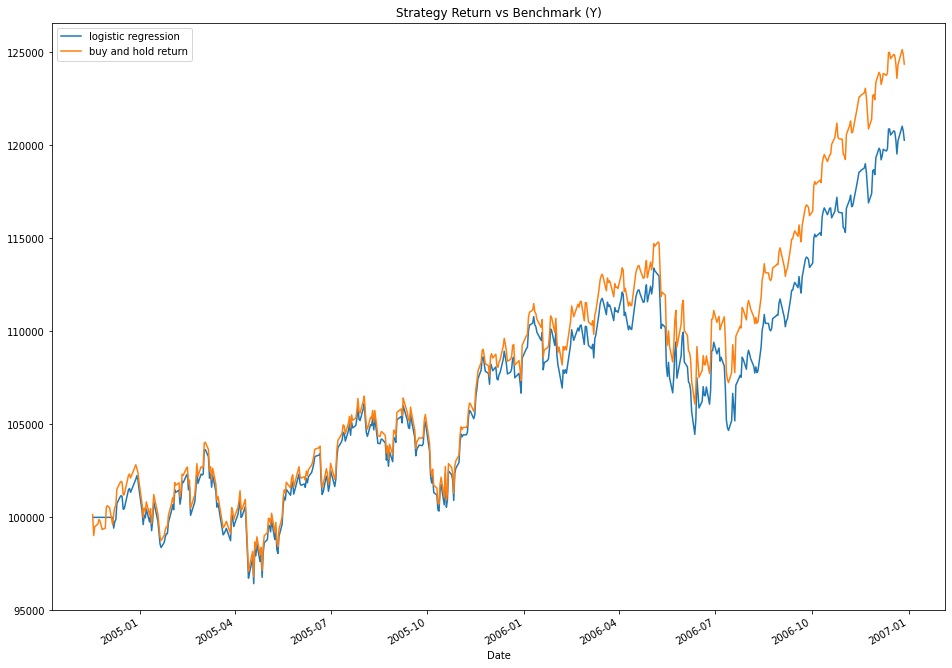

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.299e-02, tolerance: 4.655e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [ 7.48906779e-05  1.38252259e-05 -6.49107319e-05  3.87205175e-04
 -1.18745069e-07 -9.49180068e-08  4.04623942e-04 -6.84499742e-04
 -1.30527187e-03  9.77740184e-04]
intercept is 3.899 and coefficients are [-3.32730364e-02 -3.32279400e-02 -4.25505576e-02 -5.10597696e-01
 -1.53843323e-07  6.83352213e-09 -3.94299321e-01 -5.08272082e-01
 -6.20875616e-01 -4.71498605e-01]
Name of features used: ['x56' 'x72' 'x73' 'x101' 'x111' 'x116' 'x149' 'x150' 'x152' 'x153']
 
Accuracy : 0.36096938775510207
 
Precision : 0.44107142857142856
 
Recall : 0.5678160919540229


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.081e-01, tolerance: 2.176e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-de

intercept is -0.000 and coefficients are [-1.83688784e-04 -2.38628957e-04 -7.74095907e-05 -3.64076429e-03
 -1.14227938e-03 -3.67988467e-03 -3.68266847e-03 -3.66508719e-03
 -1.15476674e-03 -1.15284074e-03]
intercept is -5.841 and coefficients are [-0.00052473 -0.00071518 -0.00691333 -0.00973718 -0.10617223 -0.00980156
 -0.01016334 -0.00952938 -0.10560551 -0.10663045]
Name of features used: ['x30' 'x66' 'x67' 'x94' 'x95' 'x132' 'x133' 'x134' 'x136' 'x138']
 
Accuracy : 0.45901639344262296
 
Precision : 0.0
 
Recall : 0.0


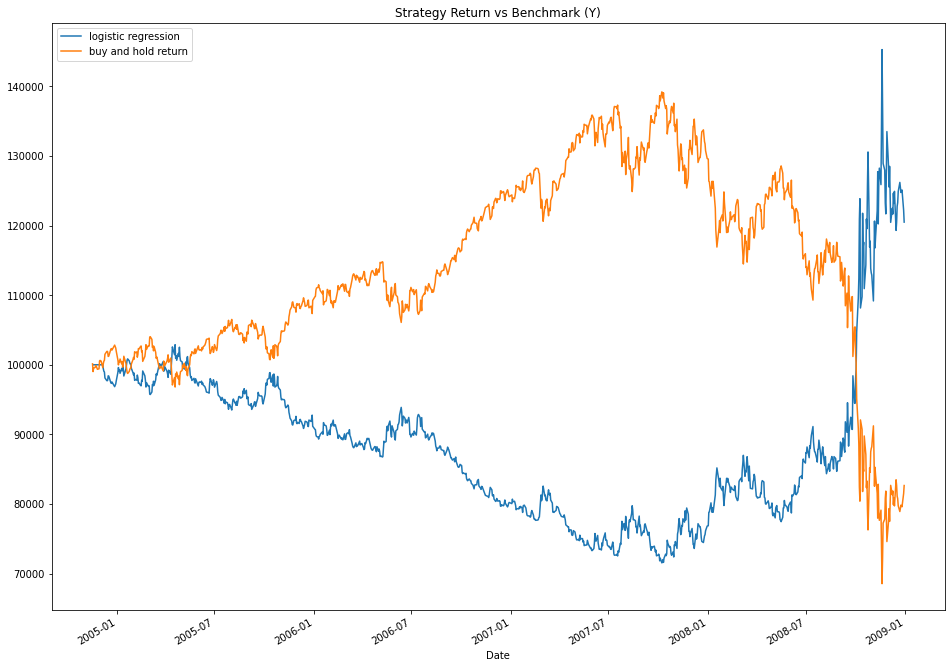

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.420e-01, tolerance: 2.878e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [-0.00014526  0.00018455 -0.00019127 -0.00286901 -0.00290776 -0.00291775
 -0.00289704 -0.00061492  0.00012521  0.00029775]
intercept is 0.802 and coefficients are [-0.00139412 -0.03829011 -0.00177013 -0.02757816 -0.02779588 -0.02806426
 -0.02760192 -0.65871249 -0.65060981 -0.64273702]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150' 'x152']
 
Accuracy : 0.2529092319627618
 
Precision : 0.3174825174825175
 
Recall : 0.32336182336182334


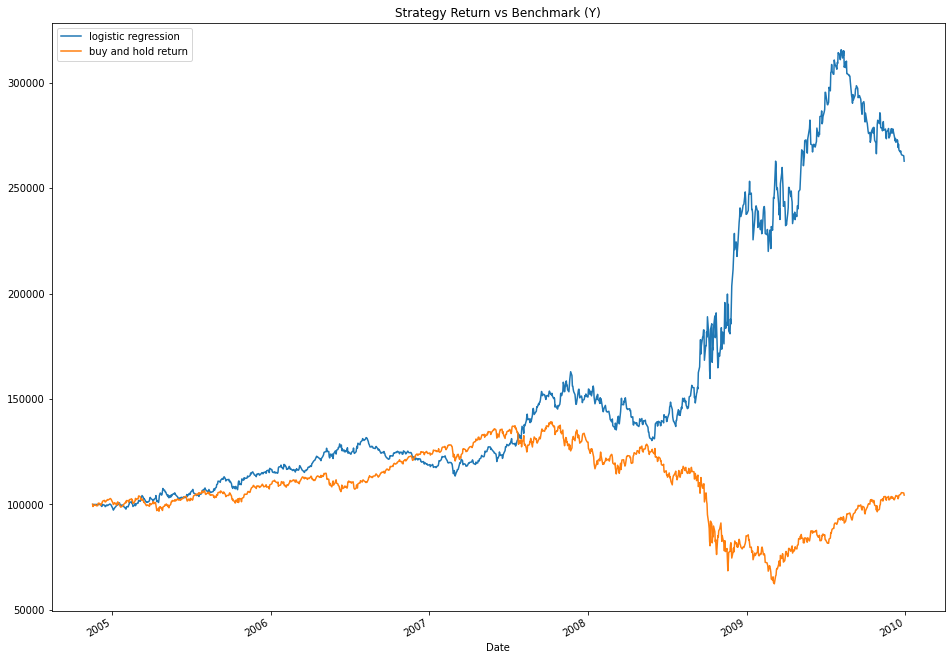

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-01, tolerance: 3.197e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [-0.00012294  0.00021258 -0.00016228 -0.00242934 -0.0024628  -0.0024717
 -0.00245483 -0.00086877  0.00022185  0.00047143]
intercept is 1.451 and coefficients are [-0.00144412 -0.03165574 -0.0018317  -0.02859815 -0.02883888 -0.02911028
 -0.02859029 -0.55678479 -0.54129656 -0.52593732]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150' 'x152']
 
Accuracy : 0.28617780661907855
 
Precision : 0.3642241379310345
 
Recall : 0.39858490566037735


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e-01, tolerance: 3.730e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [-0.00010411  0.00018965 -0.00014045 -0.00205573  0.00125683 -0.0020878
 -0.00210027 -0.00208343 -0.00207913  0.00064164]
intercept is 1.436 and coefficients are [-0.0013841  -0.03194845 -0.00171708 -0.02738505 -0.55171319 -0.02761241
 -0.02788171 -0.02734905 -0.58462857 -0.55465477]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.2799776910206358
 
Precision : 0.35559736594543745
 
Recall : 0.38414634146341464


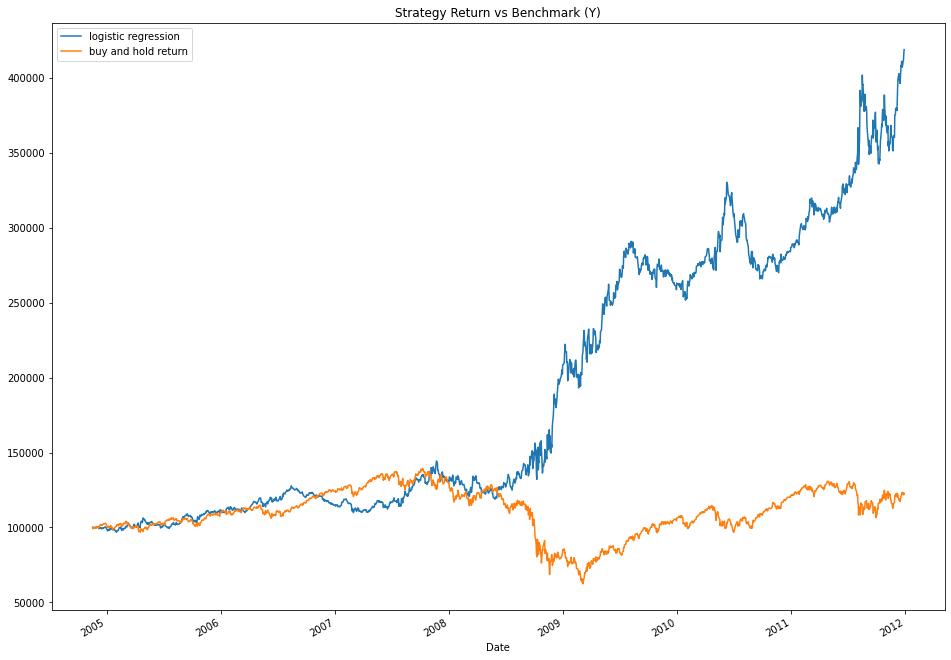

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e-01, tolerance: 3.895e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [-9.39615376e-05  2.25943066e-04 -1.26505221e-04 -1.85526218e-03
  1.22471181e-03 -1.88382785e-03 -1.89447581e-03 -1.87914456e-03
 -2.11261779e-03  7.15280253e-04]
intercept is 2.028 and coefficients are [-0.00125904 -0.02721384 -0.00154252 -0.02497598 -0.47287903 -0.02516658
 -0.02556732 -0.02491076 -0.533206   -0.48257315]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.30983847283406757
 
Precision : 0.3906131718395155
 
Recall : 0.46030330062444247


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 4.013e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [-8.55504632e-05  2.30047323e-04 -1.15207962e-04 -1.68964598e-03
  1.14929287e-03 -1.71515413e-03 -1.72466641e-03 -1.71072863e-03
 -1.91237210e-03  5.93064732e-04]
intercept is 2.605 and coefficients are [-0.00082709 -0.02300129 -0.00101715 -0.01636097 -0.42833233 -0.01674144
 -0.01699693 -0.01643484 -0.50908145 -0.43853096]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.33681917211328977
 
Precision : 0.4209547427154371
 
Recall : 0.5359116022099447


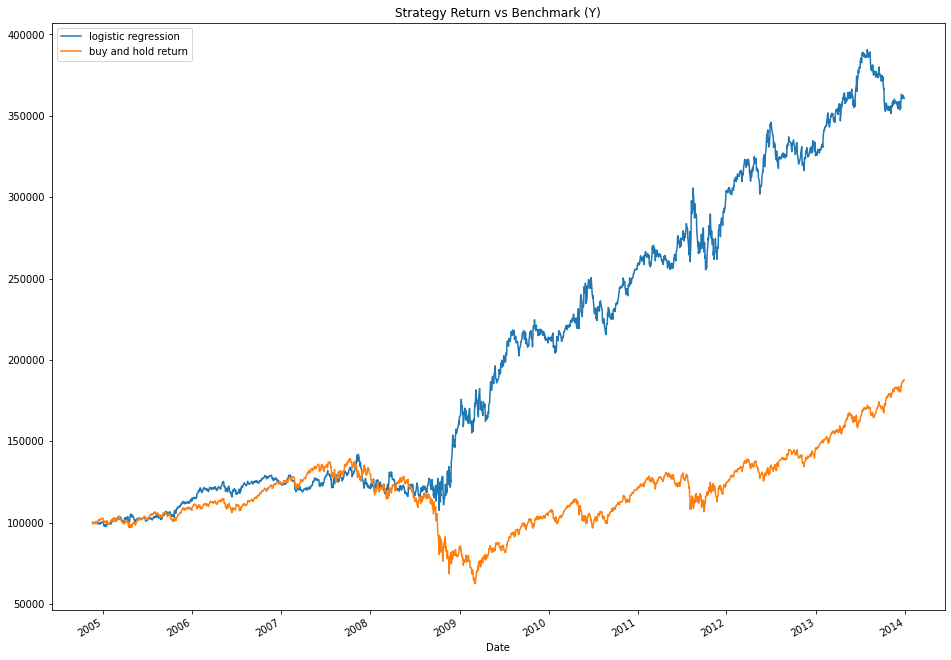

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-01, tolerance: 4.139e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [-7.78605216e-05 -1.05068250e-04 -4.11652835e-04 -1.53808226e-03
  1.15302278e-03 -1.56142794e-03 -1.57018449e-03 -1.55766789e-03
 -1.83321616e-03  5.54465138e-04]
intercept is 2.860 and coefficients are [-0.00070692 -0.00093846 -0.0341442  -0.01402398 -0.41445426 -0.01436536
 -0.01460906 -0.01410915 -0.5141606  -0.43455655]
Name of features used: ['x30' 'x66' 'x72' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.35217903415783275
 
Precision : 0.4366883116883117
 
Recall : 0.5699152542372882


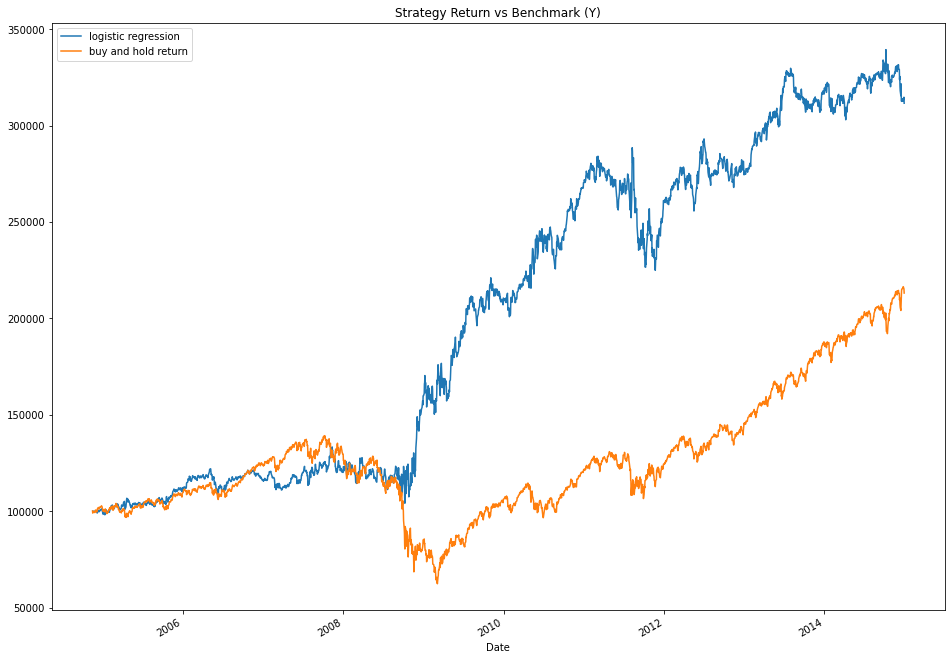

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.173e-01, tolerance: 4.379e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [-7.09273473e-05 -9.54837989e-05 -3.77575169e-04 -2.67969687e-04
 -1.39984030e-03 -1.42087698e-03 -1.43013719e-03 -1.41812270e-03
 -9.47911749e-04  8.41431557e-04]
intercept is 3.416 and coefficients are [-0.00115878 -0.00153746 -0.08015748 -0.07475206 -0.02291832 -0.023381
 -0.02374836 -0.02302699 -0.91607173 -0.81666903]
Name of features used: ['x30' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.3415505537692033
 
Precision : 0.42334669338677355
 
Recall : 0.549772283669486


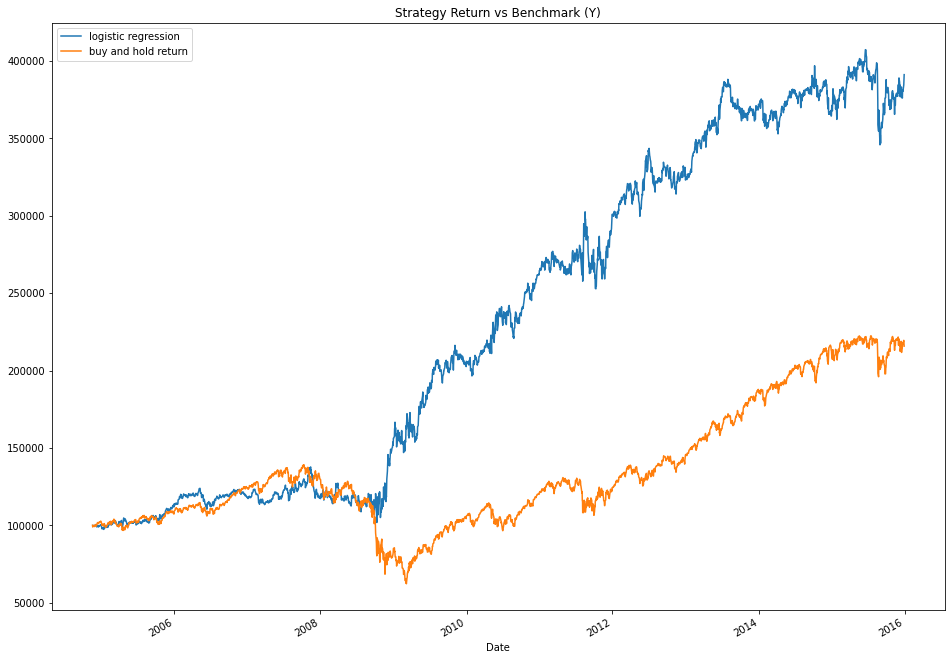

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e-01, tolerance: 4.548e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [-6.67084099e-05 -8.92437368e-05 -4.45989180e-04 -3.41321953e-04
 -1.31592423e-03 -1.33504258e-03 -1.34317813e-03 -1.33208262e-03
 -9.22947226e-04  8.25412945e-04]
intercept is 3.643 and coefficients are [-0.00124921 -0.00166371 -0.10483304 -0.0992295  -0.02467129 -0.02513352
 -0.02549791 -0.02476793 -0.88324326 -0.7797053 ]
Name of features used: ['x30' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.3503769255981645
 
Precision : 0.43118856121537086
 
Recall : 0.5764635603345281


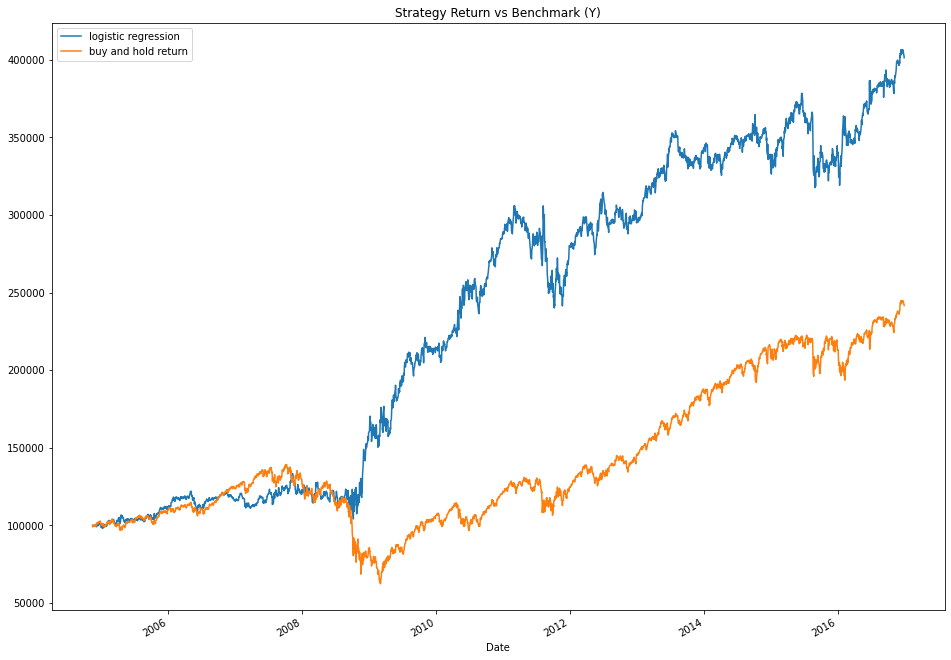

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.280e-01, tolerance: 4.593e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [-6.24094882e-05 -8.34022630e-05 -4.10018379e-04 -3.11352440e-04
 -1.23109876e-03 -1.24877624e-03 -1.25631924e-03 -1.24597920e-03
 -9.01373301e-04  7.98811251e-04]
intercept is 3.986 and coefficients are [-0.00113082 -0.00151463 -0.09966712 -0.09372977 -0.02230741 -0.0228197
 -0.02313347 -0.02234408 -0.8740456  -0.76692867]
Name of features used: ['x30' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.3749242883101151
 
Precision : 0.4510115033716779
 
Recall : 0.6257567418822234


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.427e-01, tolerance: 4.883e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [-5.74607910e-05 -7.82376069e-05 -7.71248584e-05 -3.25123868e-04
 -1.83253763e-04 -1.13419375e-03 -1.15052629e-03 -1.15843882e-03
 -1.14784408e-03 -1.02549161e-04]
intercept is 4.960 and coefficients are [-0.00237429 -0.21523466 -0.00311975 -0.21442396 -0.21502577 -0.04672127
 -0.0476711  -0.0485394  -0.04693147 -2.13406744]
Name of features used: ['x30' 'x56' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149']
 
Accuracy : 0.3664508865747256
 
Precision : 0.4436118396403147
 
Recall : 0.6071794871794872


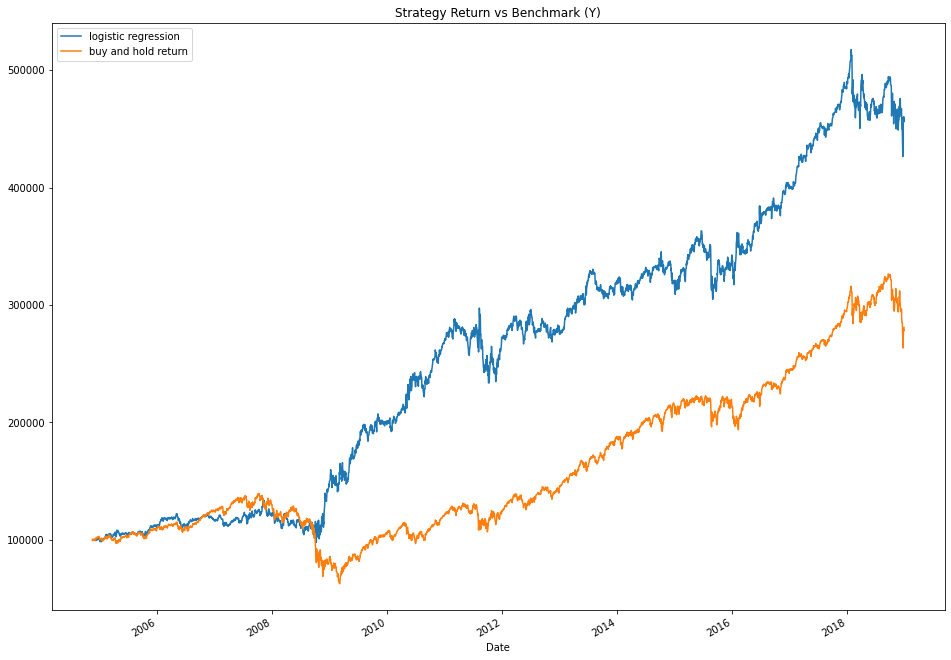

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.506e-01, tolerance: 5.041e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [-5.47791240e-05 -1.09837229e-04 -7.29802166e-05 -3.39536238e-04
 -2.03655493e-04 -1.08040581e-03 -1.09663761e-03 -1.10370183e-03
 -1.09330719e-03 -9.82295044e-05]
intercept is 5.344 and coefficients are [-0.00247449 -0.21240637 -0.0031917  -0.21093017 -0.21088523 -0.04859067
 -0.04944609 -0.05033303 -0.04862689 -1.95215658]
Name of features used: ['x30' 'x56' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149']
 
Accuracy : 0.39053876478318
 
Precision : 0.46311889525092625
 
Recall : 0.6547619047619048


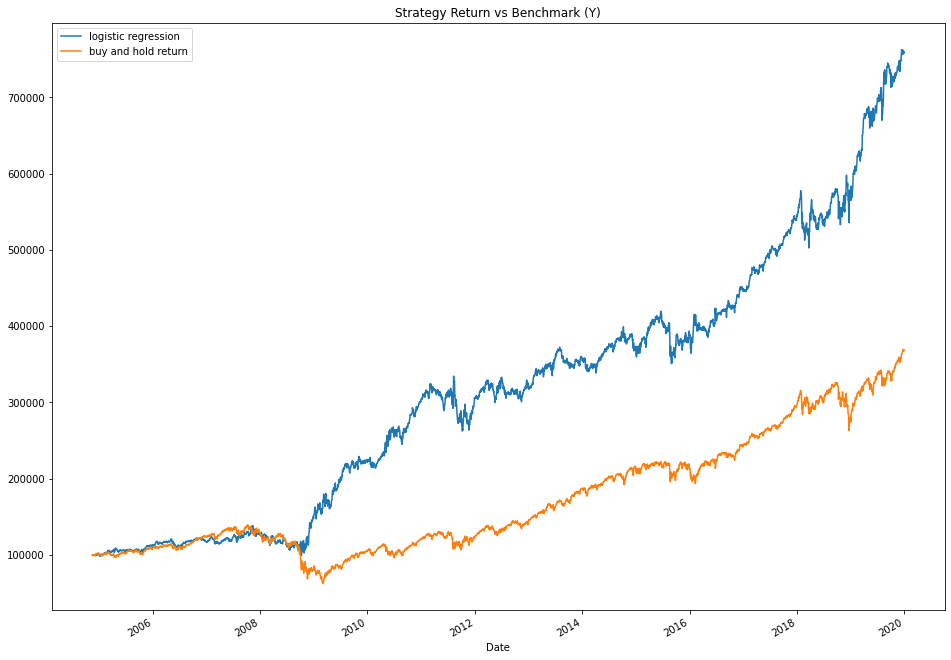

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.020e-01, tolerance: 6.175e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [-3.00307116e-06  1.49546716e-06 -2.49779170e-03 -5.11105234e-04
  9.51297352e-04  1.58825996e-03 -1.83614094e-03  5.29866185e-04
  1.52030976e-03  3.77787718e-05]
intercept is 1.735 and coefficients are [-0.00756264 -0.00668646 -0.17271097 -0.15689507 -0.1161842  -0.09147297
 -0.1403123  -0.09978803 -0.07501549 -0.0587466 ]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.3518974864465254
 
Precision : 0.4337474120082816
 
Recall : 0.5596616206589492


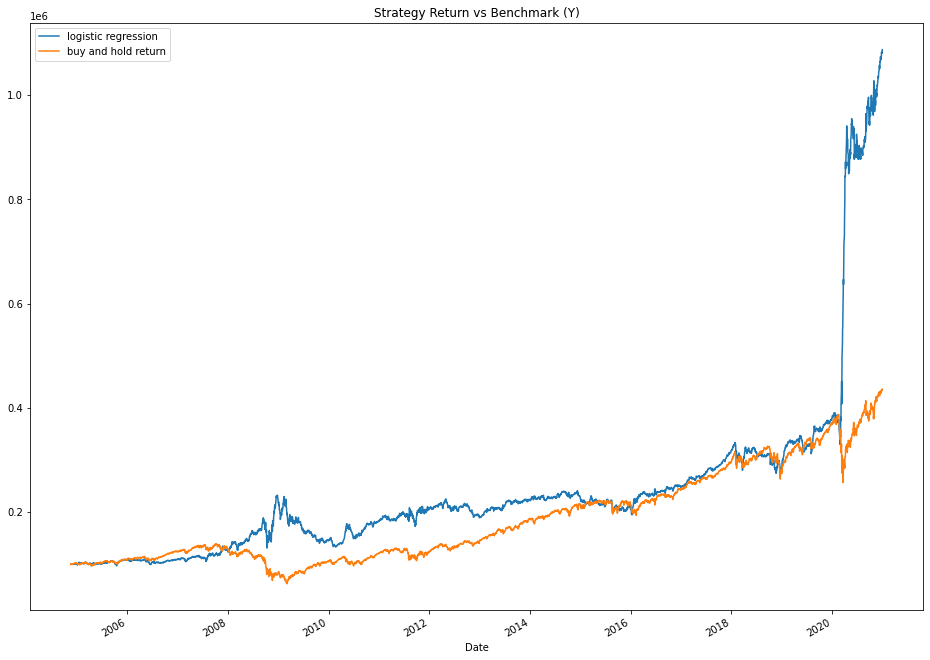

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.105e-01, tolerance: 6.342e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [ 6.97527833e-06  1.89883945e-05 -2.48029437e-03 -4.60092480e-04
  8.79952933e-04  1.57473033e-03 -1.67239796e-03  4.68263931e-04
  1.50529423e-03 -3.14727001e-05]
intercept is 1.858 and coefficients are [-0.00733253 -0.00623703 -0.17587823 -0.1559827  -0.1159035  -0.08519211
 -0.13544298 -0.09549883 -0.06465097 -0.05512066]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.3617169373549884
 
Precision : 0.4432141727301487
 
Recall : 0.5857023411371237


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.403e-01, tolerance: 6.930e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [ 6.40080648e-05  8.35266745e-05 -2.39059426e-03 -3.49762661e-04
  7.80946955e-04  1.58050592e-03 -1.53243764e-03  3.86710285e-04
  1.51857961e-03 -1.99963926e-04]
intercept is 1.827 and coefficients are [-0.00786906 -0.00678987 -0.18034952 -0.16078182 -0.12614708 -0.08886255
 -0.14053953 -0.10603833 -0.06864891 -0.07120665]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.3499232624424468
 
Precision : 0.42879066912216085
 
Recall : 0.5585765693722511


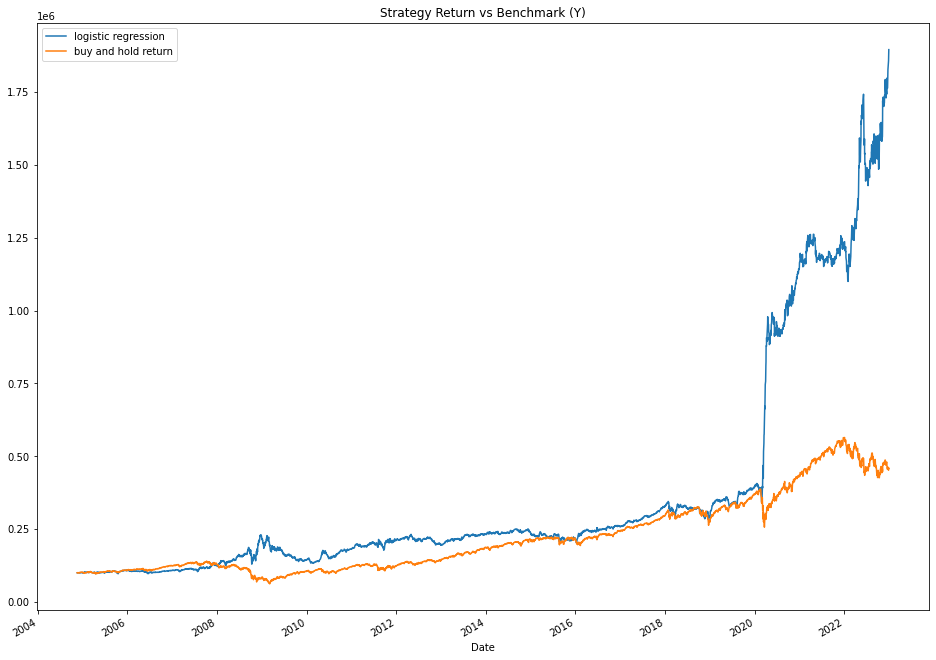

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.478e-01, tolerance: 7.079e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_24490/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

intercept is 0.000 and coefficients are [ 7.66162193e-05  9.80849386e-05 -2.39245622e-03 -3.43325641e-04
  7.63538884e-04  1.58008133e-03 -1.48629899e-03  3.69918732e-04
  1.51665166e-03 -2.11867234e-04]
intercept is 1.880 and coefficients are [-0.00798155 -0.00674785 -0.185083   -0.16267784 -0.12812988 -0.08998906
 -0.13957815 -0.10510432 -0.06683686 -0.07039193]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.34598448312015095
 
Precision : 0.4255630301257678
 
Recall : 0.5574712643678161


Date
2004-11-17          NaN
2004-11-18     1.000000
2004-11-19     1.000000
2004-11-22     1.000000
2004-11-23     1.000000
                ...    
2023-10-23    20.404607
2023-10-24    20.111757
2023-10-25    19.870926
2023-10-26    19.780856
2023-10-27    20.017351
Name: strategy_return, Length: 4769, dtype: float64

In [218]:
Y_traintest2 = Y_traintest.shift(-1).loc[index_]

params, X_traintest5= fit_and_predict_w_short(df_dict,Y_traintest2,penalty_)



In [219]:
(X_traintest5["strategy_return"].cumsum().apply(np.exp))

Date
2004-11-17          NaN
2004-11-18     1.000000
2004-11-19     1.000000
2004-11-22     1.000000
2004-11-23     1.000000
                ...    
2023-10-23    20.404607
2023-10-24    20.111757
2023-10-25    19.870926
2023-10-26    19.780856
2023-10-27    20.017351
Name: strategy_return, Length: 4769, dtype: float64

# CART (decision tree)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

DT_model = DecisionTreeRegressor() #can adjust the max depth


#X are the exogenous variables & y is the endogenous variable
DT_model.fit()


In [182]:
# Model Specification

penalty_ = 0.0

def fit_and_predict_DT(df_dict,Y_traintest_series,penalty_):
    params_dict = {}
    
    for year_ in years_in_data:
        
        X_index = df_dict[year_].index 
        Y_traintest_series_fraction = Y_traintest_series.loc[X_index]

        DT_model = DecisionTreeRegressor(criterion = "squared_error")

        DT_model.fit(df_dict[year_], Y_traintest_series_fraction)

        DT_pred_train2 = DT_model.predict(df_dict[year_])
        
        train_result = mean_squared_error(DT_pred_train2, Y_traintest_series_fraction)

        DT_pred_train2_df = pd.DataFrame(DT_pred_train2, index = df_dict[year_].index)
        
        print("MSE is {}".format(train_result))

#         params_dict[f"EN_pred_{year_}"] = EN_pred_train2
#         params_dict[f"binary_pred_{year_}"] = Y_pred_binary2
#         params_dict[f"logistic_pred_{year_}"] = Y_pred_logistic2_df

#         params_dict[f"Accuracy_{year_}"] = metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2)
#         params_dict[f"Precision_{year_}"] = metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
#         params_dict[f"Recall_{year_}"] = metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
                                                            
#         print("Name of features used: {}".format(elastic_net.feature_names_in_))
#         print(" ")
#         print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2))
#         print(" ")
#         print("Precision :", metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
#         print(" ")
#         print("Recall :", metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))

        
        X_traintest3 = df_dict[year_].copy()
        X_traintest3["signal"] = DT_pred_train2_df
        X_traintest3["signal"].iloc[:12] = 0

        X_traintest3["strategy_return"] = X_traintest3["signal"].shift(1) * Y
        fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

        (X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")

        (Y.loc[X_index].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

        ax.legend()
        ax.set_title('Strategy Return vs Benchmark (Y)')
        plt.show()
    
    return params_dict, X_traintest3

MSE is 0.0


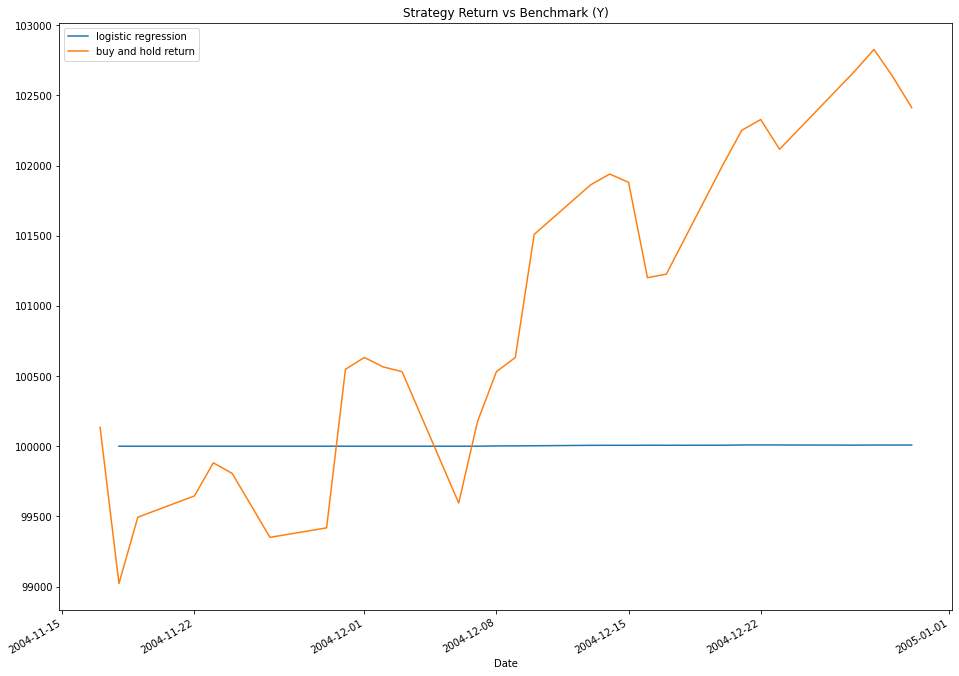

MSE is 0.0


MSE is 0.0


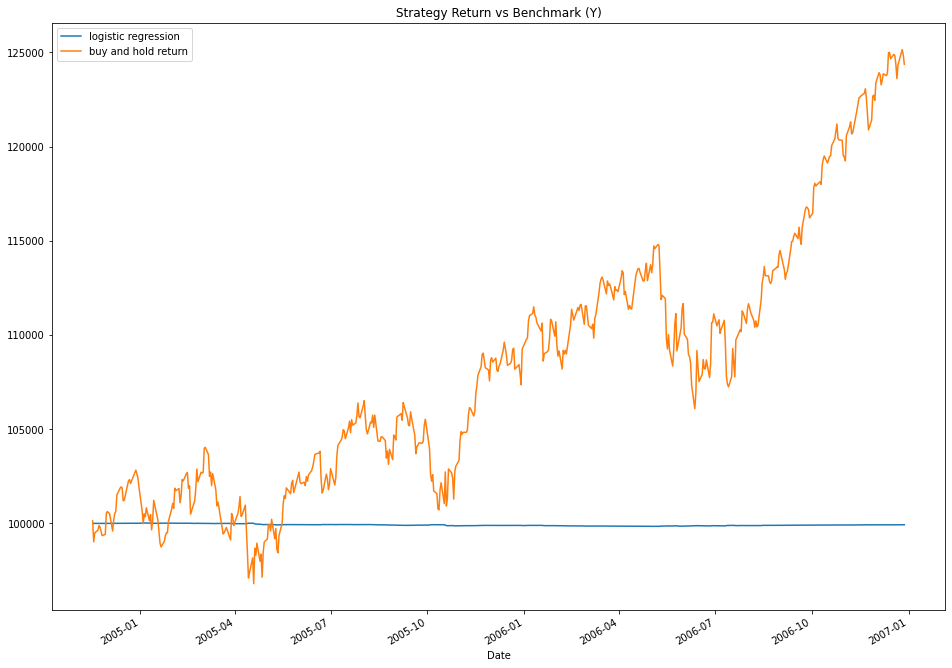

MSE is 0.0


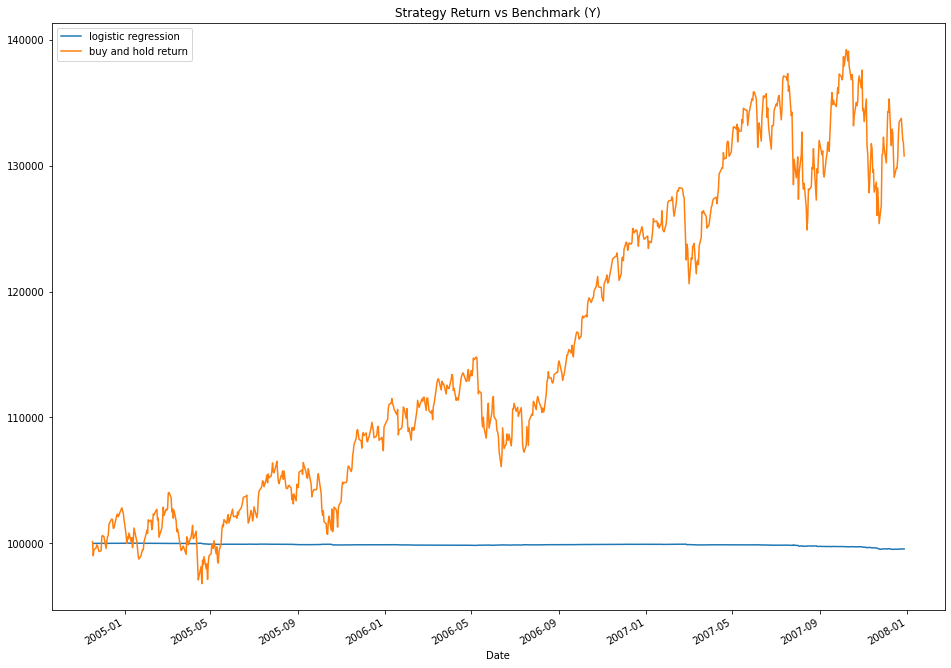

MSE is 0.0


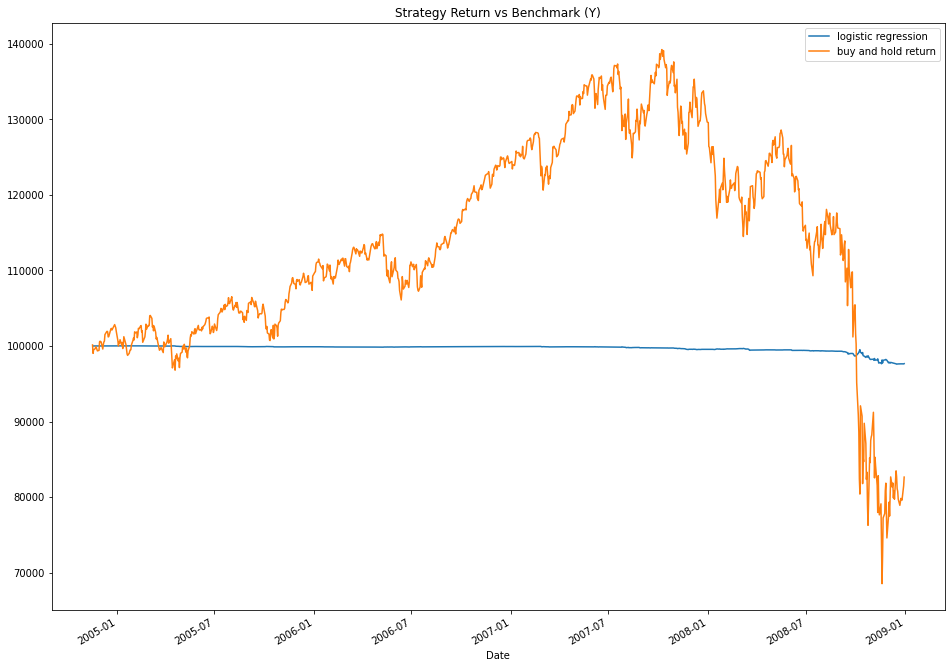

MSE is 0.0


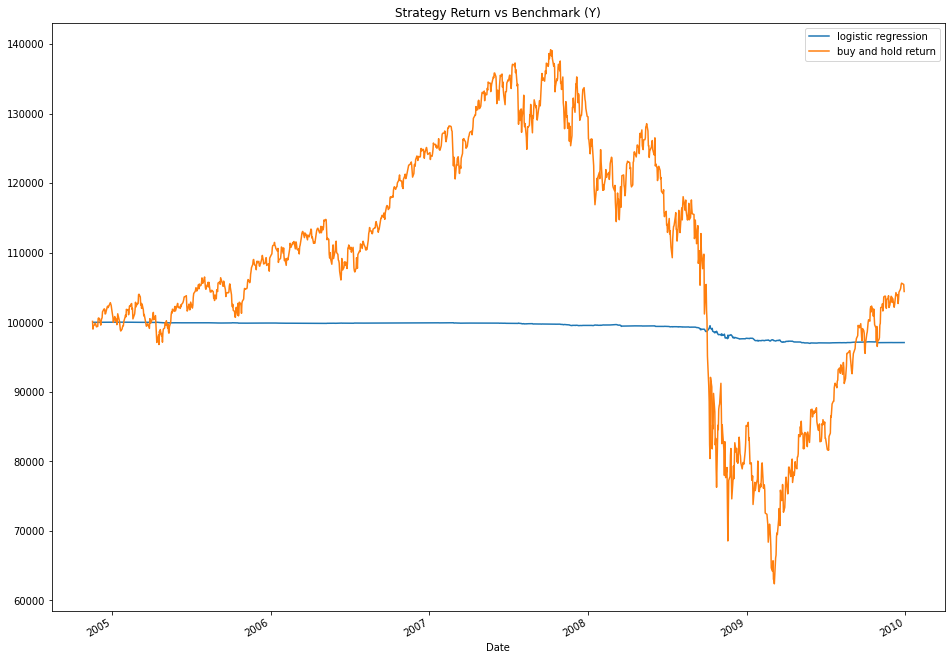

MSE is 0.0


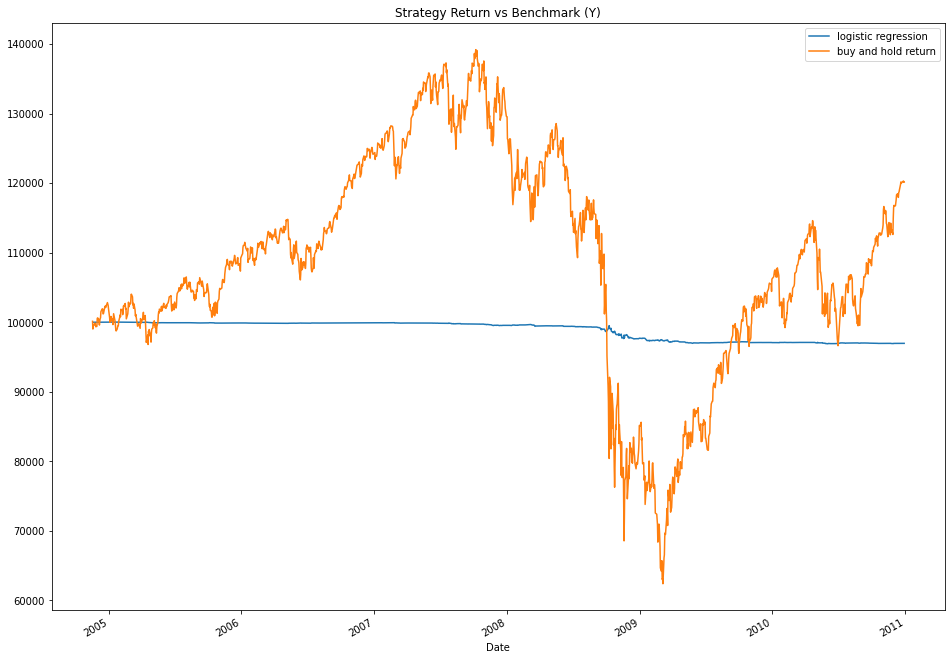

MSE is 0.0


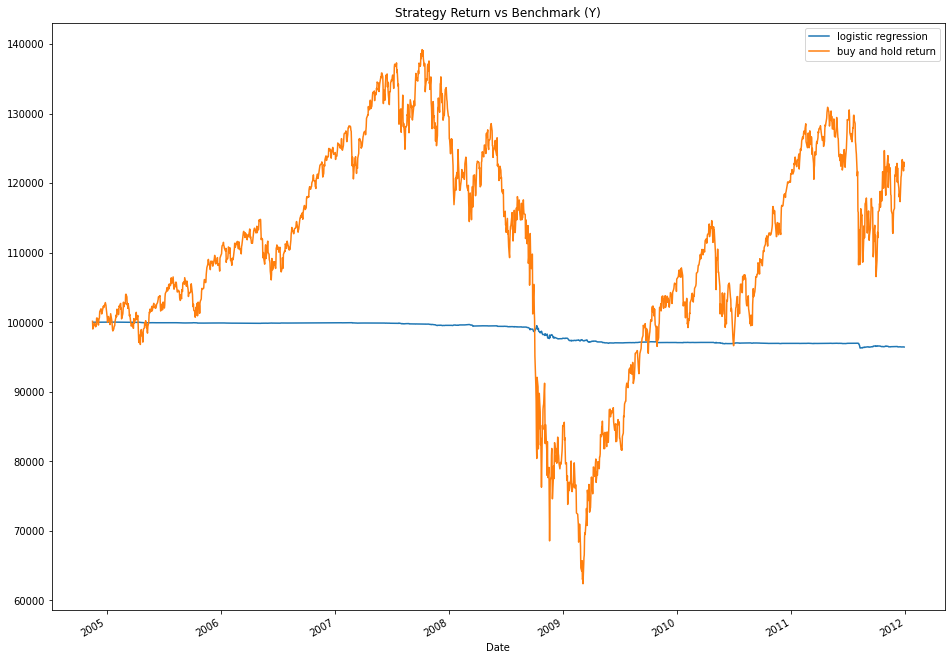

MSE is 0.0


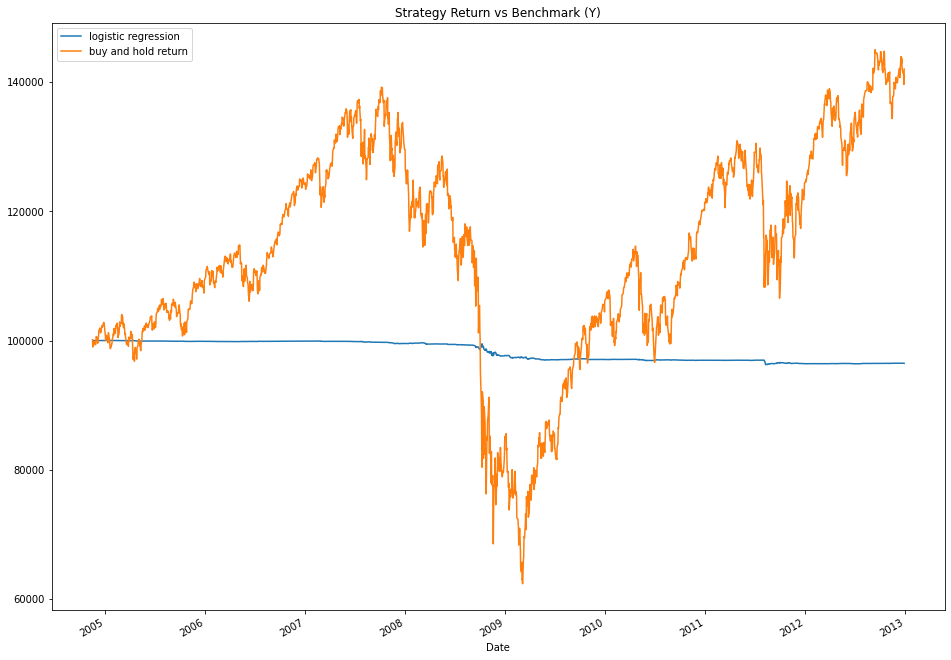

MSE is 0.0


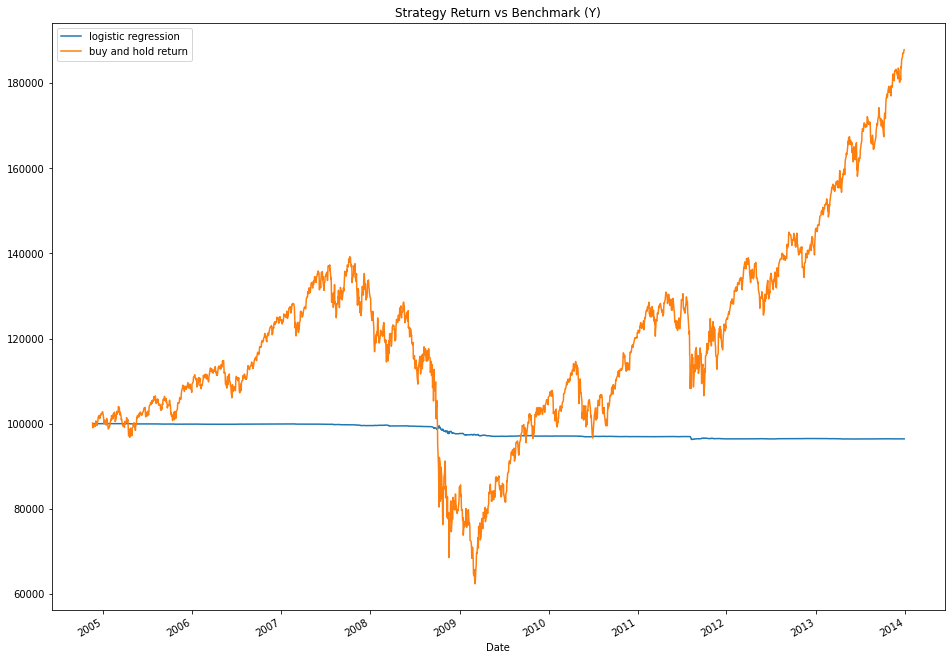

MSE is 0.0


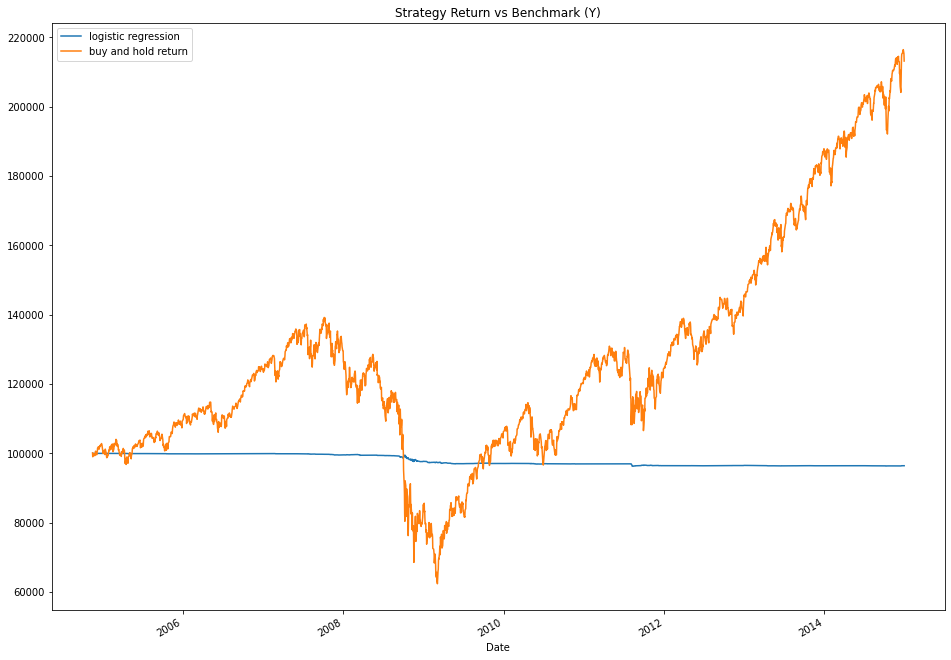

MSE is 0.0


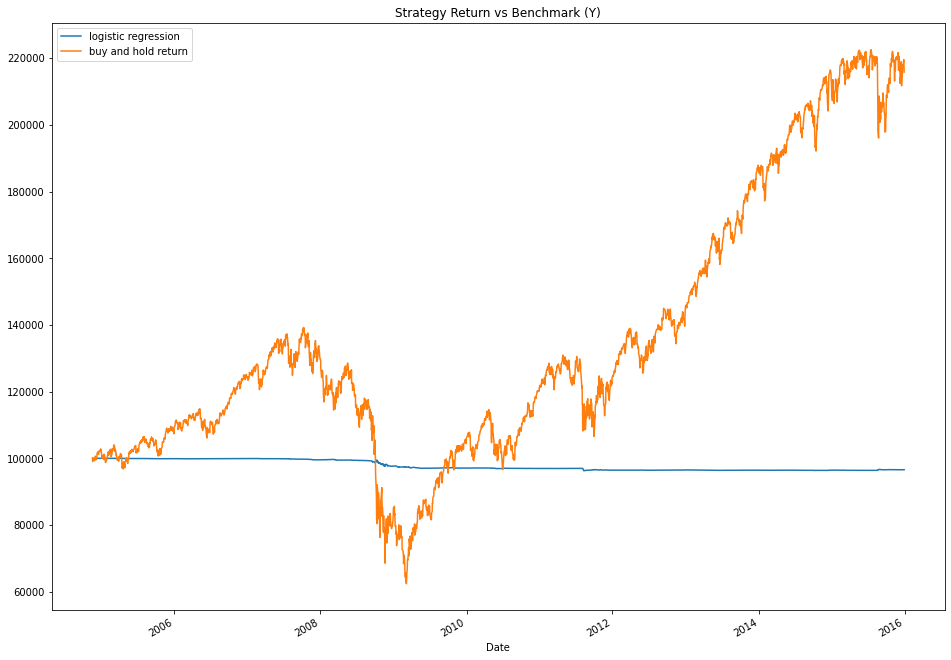

MSE is 0.0


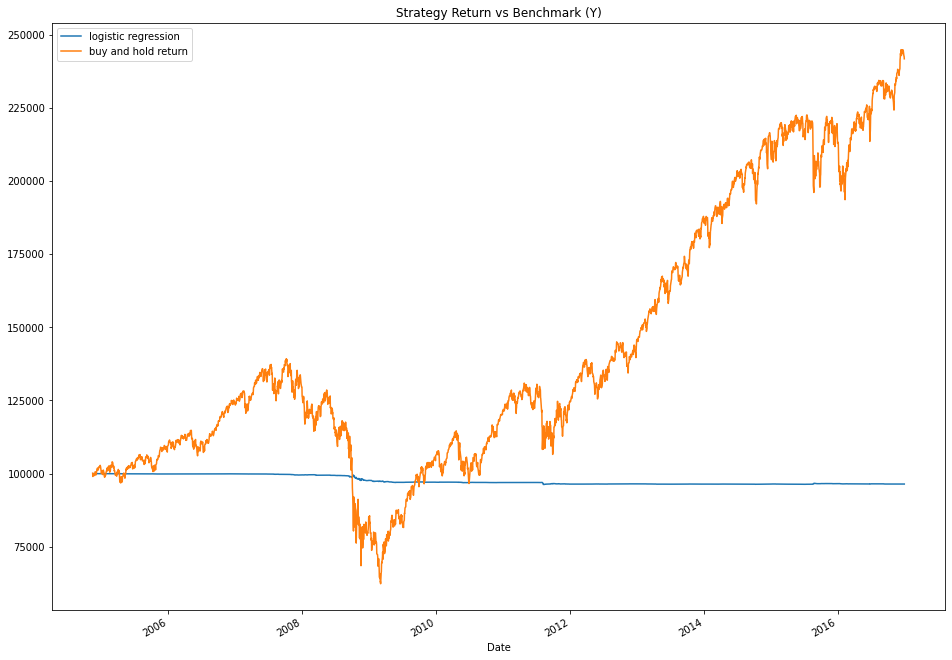

MSE is 0.0


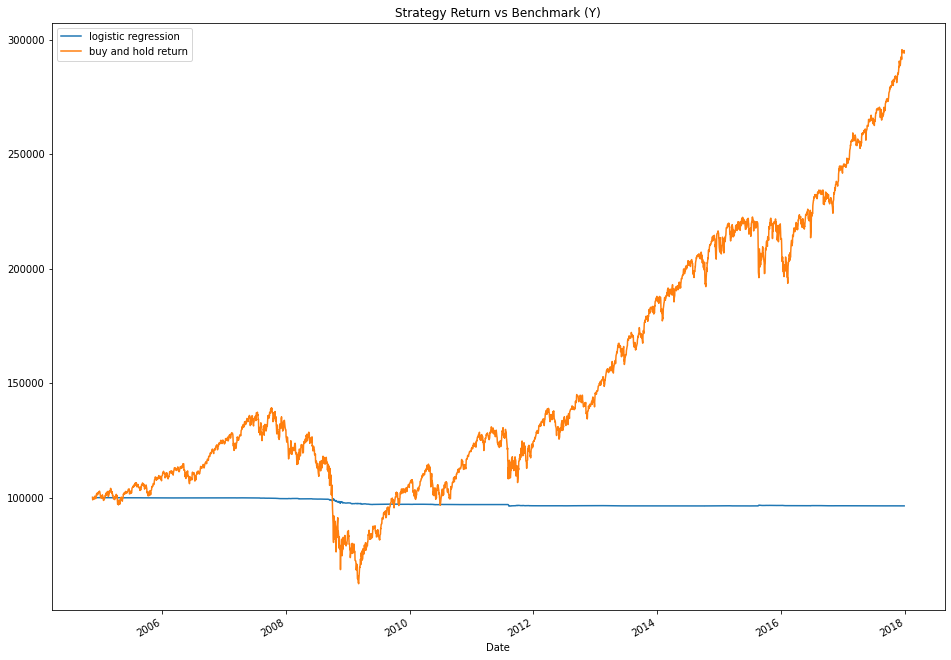

MSE is 0.0


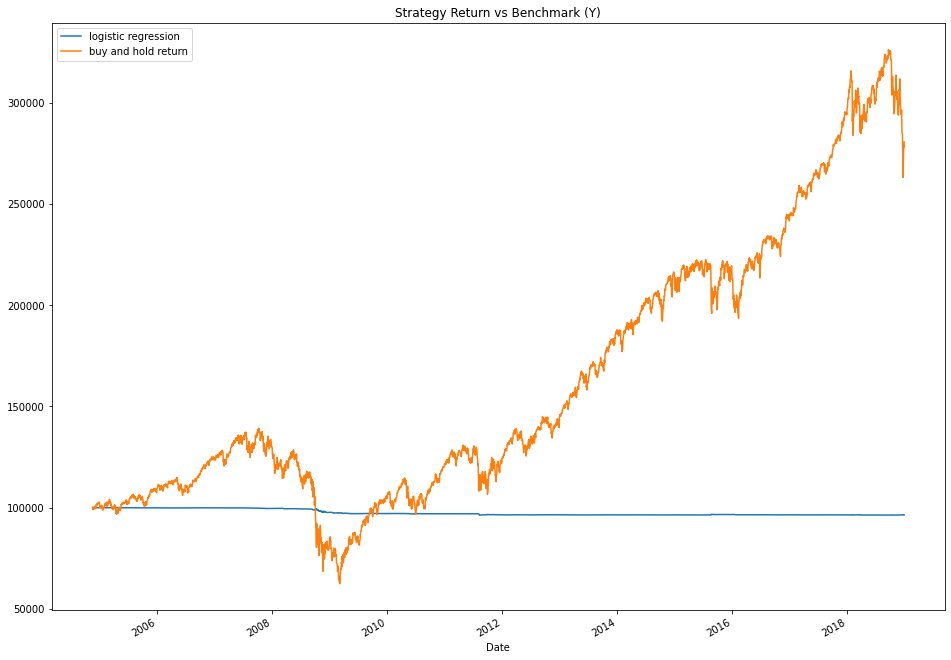

MSE is 0.0


MSE is 0.0


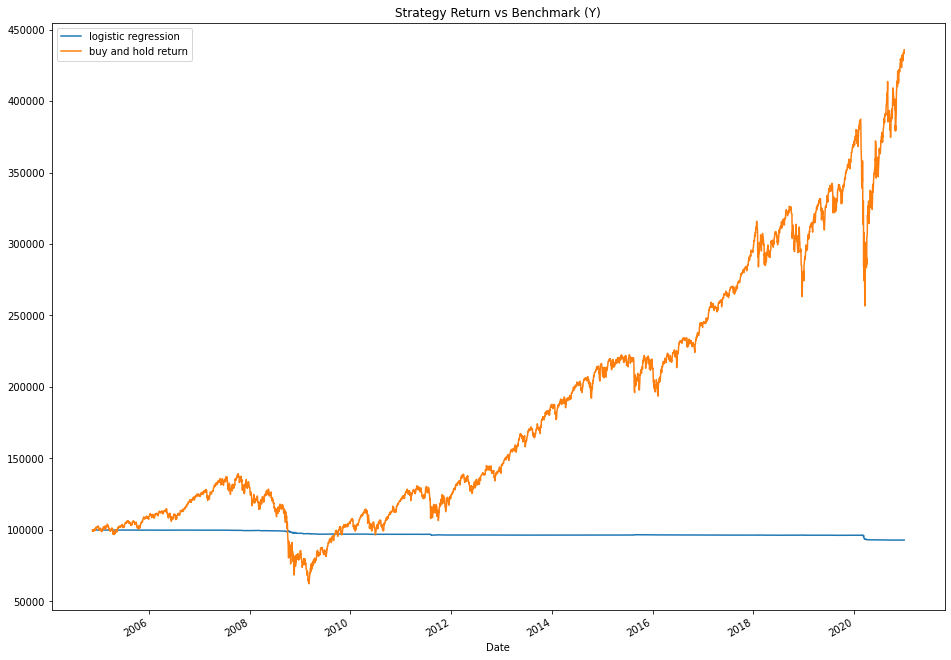

MSE is 0.0


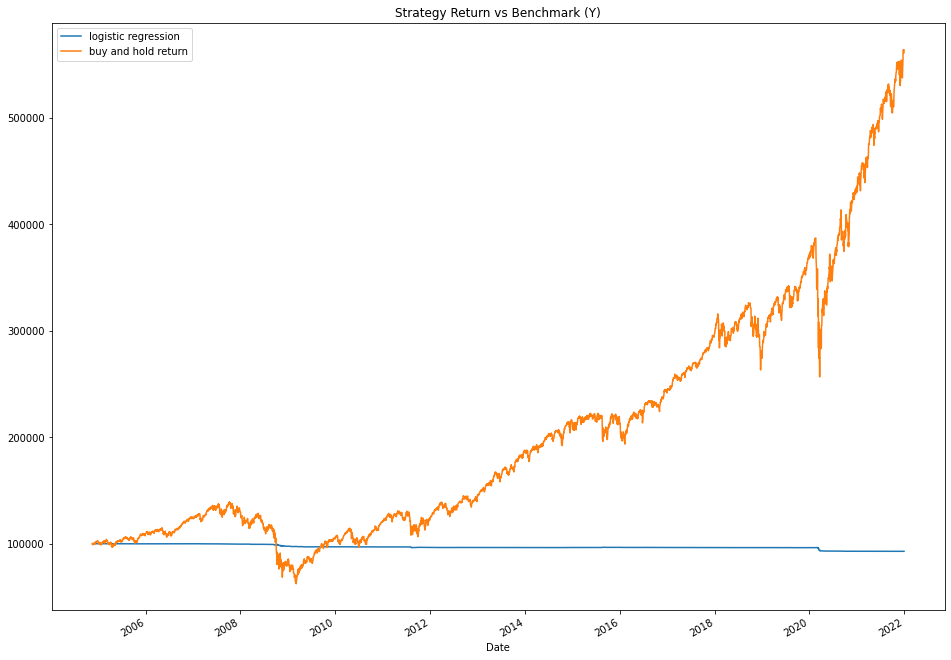

MSE is 0.0


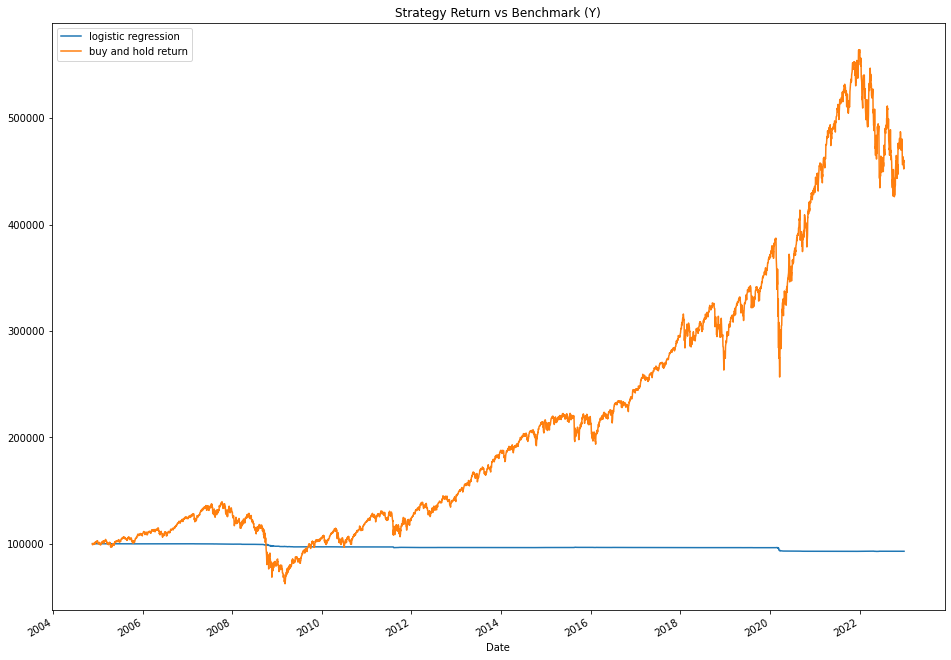

MSE is 0.0


In [183]:
dummy_df = fit_and_predict_DT(df_dict,Y_traintest,penalty_)[1]

<Axes: >

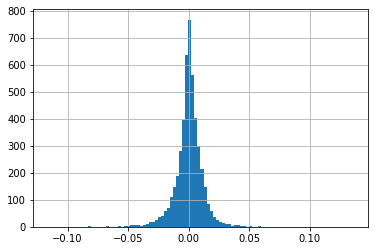

In [181]:
dummy_df["signal"].hist(bins=100)